In [193]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [194]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

In [195]:
df = pd.read_csv('f1_data_2021_2025.csv')
df.head()

,season,round,event_name,location,event_date,driver_code,driver_number,driver_name,team_name,grid_position,...,total_pit_time_sec,n_stints,compounds_used,RainProbability,TrackTemp,CleanAirPace,Sector1_Ratio,Sector2_Ratio,Sector3_Ratio,Quali_Delta_Pole
0,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,44,44,Lewis Hamilton,Mercedes,2.0,...,0.0,3,"MEDIUM, HARD",0.0,27.62782,94.1076,0.988240,0.987896,0.990400,0.388
1,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,33,33,Max Verstappen,Red Bull Racing,1.0,...,0.0,3,"MEDIUM, HARD",0.0,27.62782,93.4158,0.991288,0.985032,0.994308,0.000
2,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,77,77,Valtteri Bottas,Mercedes,3.0,...,0.0,4,"MEDIUM, HARD",0.0,27.62782,93.8188,0.987010,0.988566,0.992470,0.589
3,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,4,4,Lando Norris,McLaren,7.0,...,0.0,3,"SOFT, MEDIUM, HARD",0.0,27.62782,94.5812,0.999922,0.992425,1.001106,0.977
4,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,11,11,Sergio Perez,Red Bull Racing,0.0,...,0.0,4,"MEDIUM, HARD",0.0,27.62782,94.1812,0.999403,0.992827,1.001056,1.662


### Visão Geral

- Season
- Round
- Event_name
- Location
- Event_date
- Driver_code
- Driver_number
- Driver_name
- Team_name
- Grid_position
- Final_position
- Status
- Points
- Total_time_sec
- Fastest_lap_time_sec
- Std_lap_time_sec
- Clean_avg_lap_time_sec
- N_pitstops
- Total_pit_time_sec
- N_stints
- Compounds_used

In [196]:
df.shape

(2278, 30)

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   season                  2278 non-null   int64  
 1   round                   2278 non-null   int64  
 2   event_name              2278 non-null   object 
 3   location                2278 non-null   object 
 4   event_date              2278 non-null   object 
 5   driver_code             2278 non-null   int64  
 6   driver_number           2278 non-null   int64  
 7   driver_name             2278 non-null   object 
 8   team_name               2278 non-null   object 
 9   grid_position           2275 non-null   float64
 10  final_position          2275 non-null   float64
 11  status                  2278 non-null   object 
 12  points                  2278 non-null   float64
 13  total_time_sec          1715 non-null   float64
 14  laps_completed          2278 non-null   

#### Tratamento de nulos

Variáveis de posições (grid_position, final_position) > nulos indicam que o piloto não largou ou foi desclassificado.

A estratégia é de preencher com 20 (último lugar), de modo a penalizar o piloto

In [198]:
cols_pos = ['grid_position', 'final_position']
for col in cols_pos:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(20)

Variáveis de métricas de contagem/acúmulo (points, n_stints, total_pit_time_sec) > nulos representam que nenhum evento foi registrado, logo a estratégia é de preencher os valores com 0

In [199]:
cols_zero = ['points', 'n_pitstops', 'total_pit_time_sec', 'n_stints']
for col in cols_zero:
  df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

Variáveis de tempos de volta (avg_lap_time, best_lap_tme, total_time_sec) > Preenche-se com os piores tempos de coluna, pois se for preenchido com 0 infere-se que o piloto foi muito rápido e teve 0 segundos de corrida.

In [200]:
df.columns

Index(['season', 'round', 'event_name', 'location', 'event_date',
       'driver_code', 'driver_number', 'driver_name', 'team_name',
       'grid_position', 'final_position', 'status', 'points', 'total_time_sec',
       'laps_completed', 'avg_lap_time_sec', 'best_lap_time_sec',
       'std_lap_time_sec', 'clean_avg_lap_time_sec', 'n_pitstops',
       'total_pit_time_sec', 'n_stints', 'compounds_used', 'RainProbability',
       'TrackTemp', 'CleanAirPace', 'Sector1_Ratio', 'Sector2_Ratio',
       'Sector3_Ratio', 'Quali_Delta_Pole'],
      dtype='object')

In [201]:
cols_time = [
    'total_time_sec', 
    'best_lap_time_sec', 
    'avg_lap_time_sec',  
    'clean_avg_lap_time_sec',
    'CleanAirPace'
]

In [202]:
for col in cols_time:
    # Convertemos para numérico primeiro
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # Pegamos o pior tempo de todo o histórico (max)
    worst_time = df[col].max()
    # Preenchemos os nulos com esse tempo
    df[col] = df[col].fillna(worst_time)

Variável de consistência (std_lap_time_sec) > assume-se que a falta de dados é algo negativo, então é preenchido com o máximo desvio que significa alta inconsistêncoa

In [203]:
max_std = df['std_lap_time_sec'].max()
df['std_lap_time_sec'] = df['std_lap_time_sec'].fillna(max_std)

Variáveis de texto e categoria preenchidas com string de "desconhecido"

In [204]:
df['compounds_used'] = df['compounds_used'].fillna("UNKNOWN")
df['status'] = df['status'].fillna("DNF") # Caso raro, mas seguro

In [205]:
cols_sectors = ['Sector1_Ratio', 'Sector2_Ratio', 'Sector3_Ratio']
for col in cols_sectors:
  if col in df.columns:
      df[col] = df[col].fillna(1.0)

In [206]:
if 'Quali_Delta_Pole' in df.columns:
  # Fórmula: (Posição - 1) * 0.15 segundos (estimativa grosseira de gap por posição)
  estimated_gap = (df['grid_position'] - 1) * 0.15
  df['Quali_Delta_Pole'] = df['Quali_Delta_Pole'].fillna(estimated_gap)
  # Garante que não ficou negativo
  df['Quali_Delta_Pole'] = df['Quali_Delta_Pole'].clip(lower=0.0)

In [207]:
print(df.isnull().sum().sum(), "valores nulos restantes.")

0 valores nulos restantes.


#### Estatísticas e Visualização inicial

In [208]:
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['font.family'] = 'sans-serif'

f1_red = '#e30708'      
carbon_black = '#1A1A1A'
track_grey = '#6E6E6E'

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']   = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

In [209]:
df[['grid_position', 'final_position', 'laps_completed', 'n_pitstops']].describe()

,grid_position,final_position,laps_completed,n_pitstops
count,2278.000000,2278.000000,2278.000000,2278.000000
mean,10.302897,10.491659,54.896839,1.894205
std,5.804493,5.763199,16.913778,1.076255
min,0.000000,1.000000,0.000000,0.000000
25%,5.000000,5.250000,51.000000,1.000000
50%,10.000000,10.000000,57.000000,2.000000
75%,15.000000,15.000000,69.000000,2.000000
max,20.000000,20.000000,78.000000,7.000000


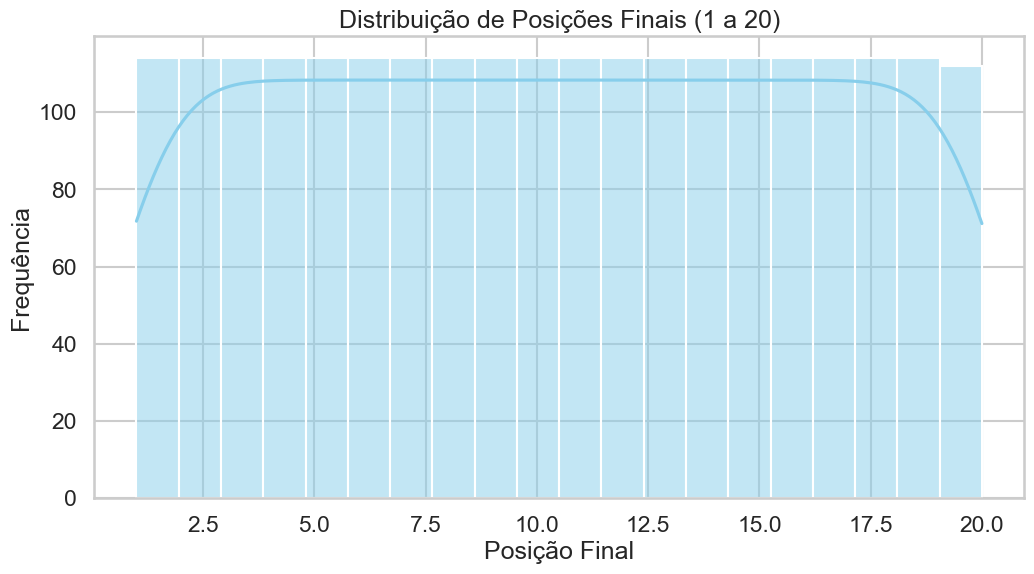

In [210]:
plt.figure(figsize=(12, 6))
sns.histplot(df['final_position'], bins=20, kde=True, color='skyblue')
plt.title('Distribuição de Posições Finais (1 a 20)')
plt.xlabel('Posição Final')
plt.ylabel('Frequência')
plt.show()

A imagem demonstra que o dataset está completo e equilibrado, sem "buracos", ou seja, dados irregulares 

O gráfico mostra uma correlação positiva entre a posição de largada e a posição final. Quanto menor a posição de largada, temos uma posição final consequentemente menor, também.
A bola azul, na posição 1,1 por exemplo que tem uma tonalidade mais forte, indica que muitos pilotos chegaram no resultado de largar em 1o e chegar em 1o 

#### Numerical columns

--- Génération des graphiques style F1 pour 19 variables ---


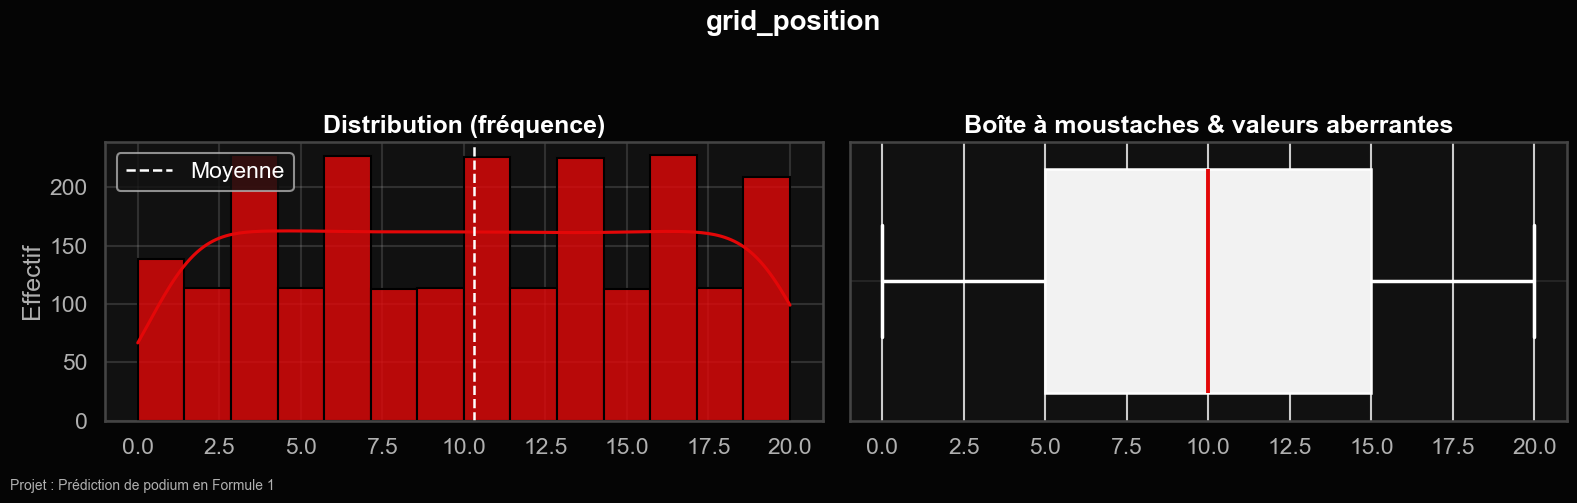

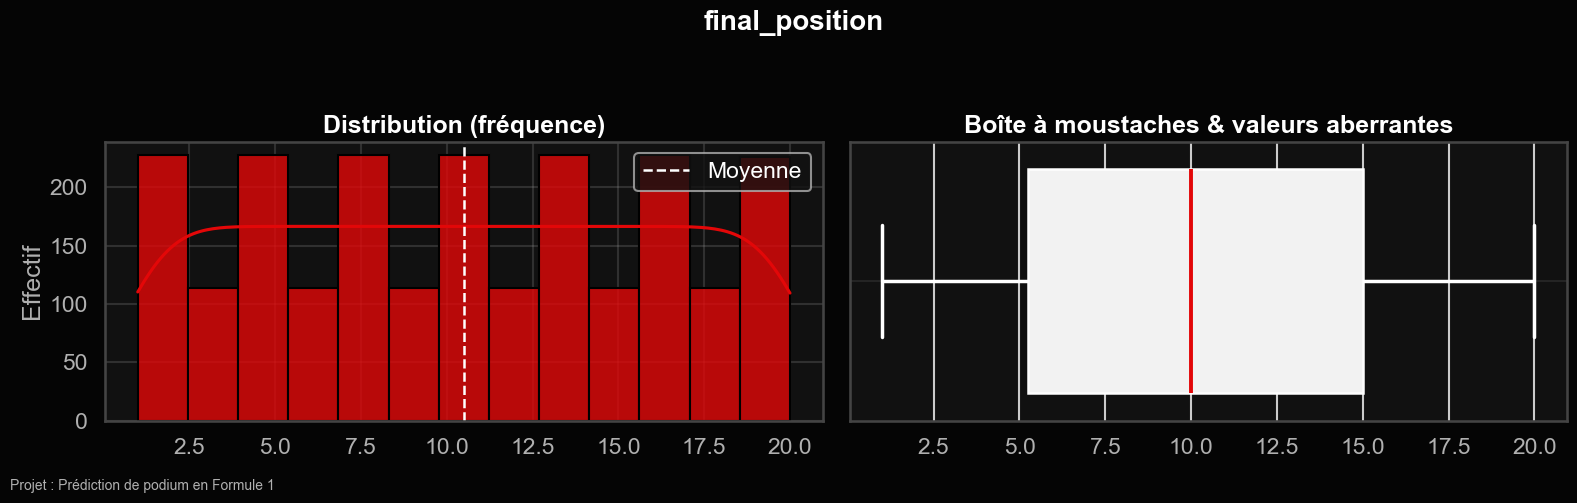

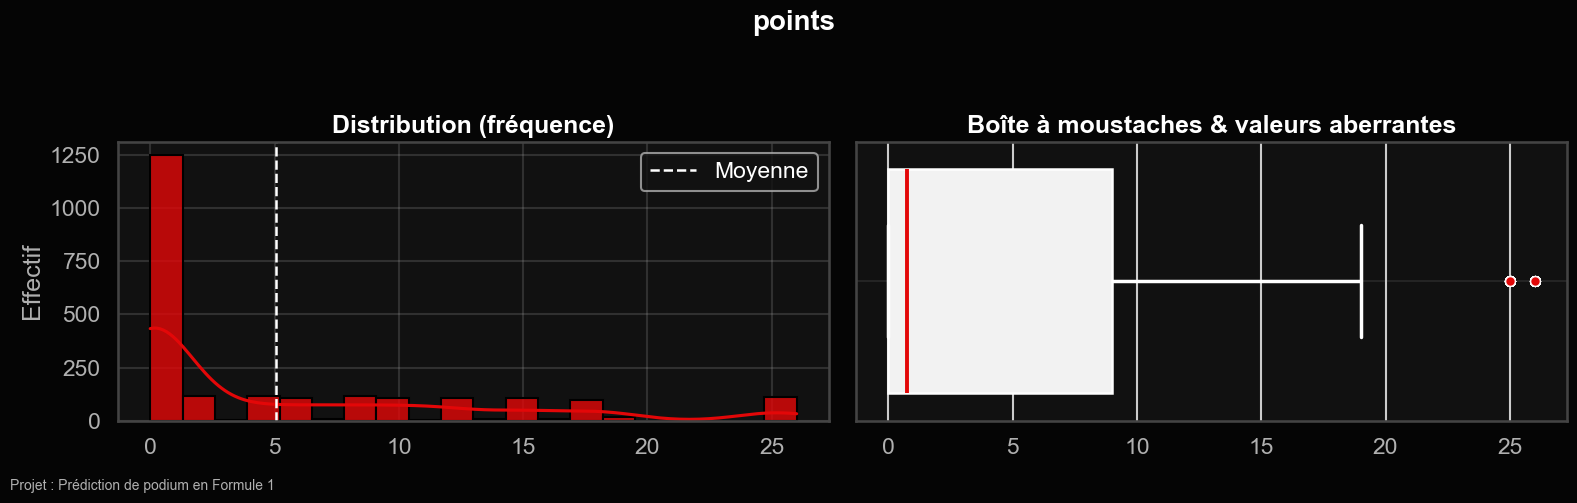

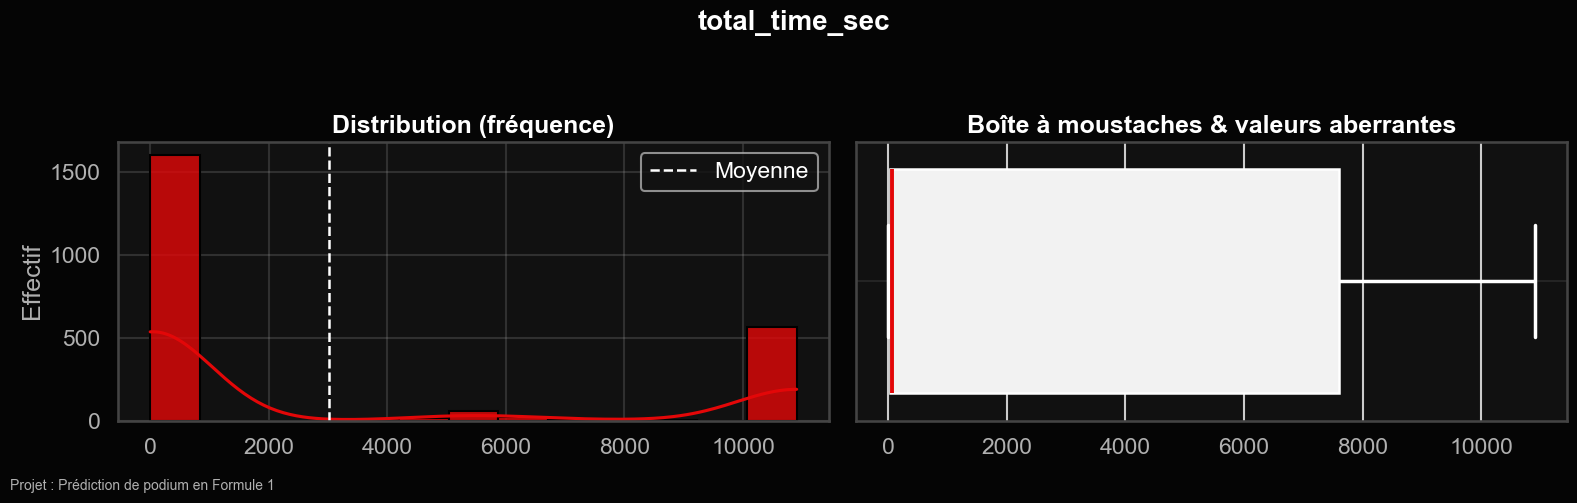

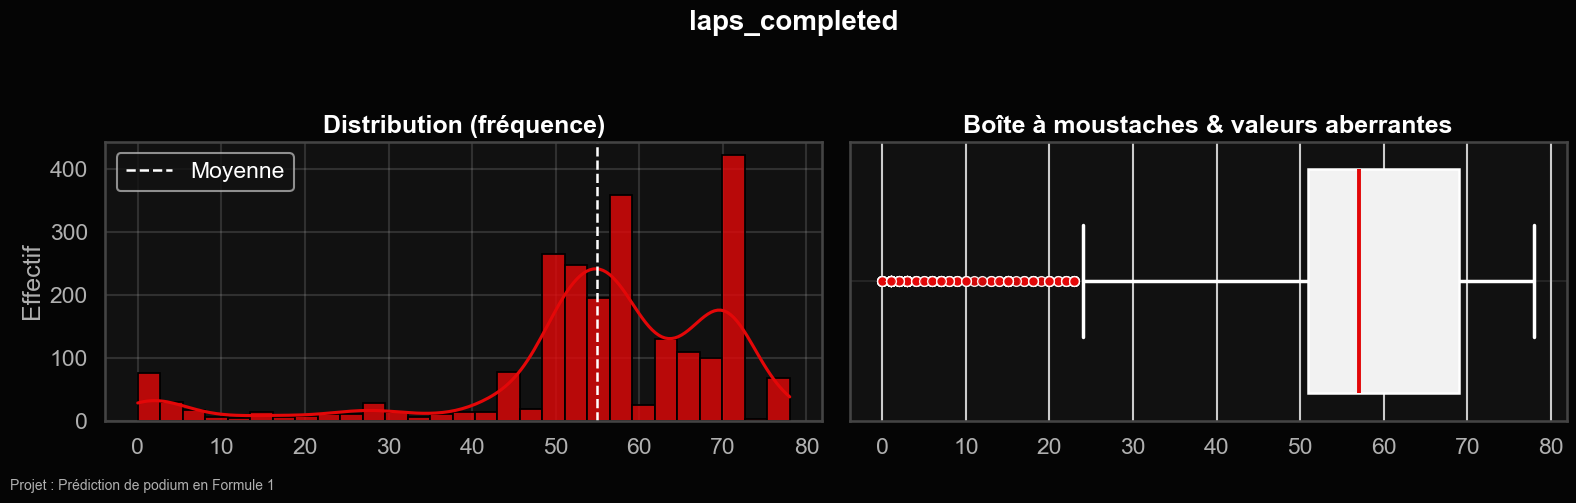

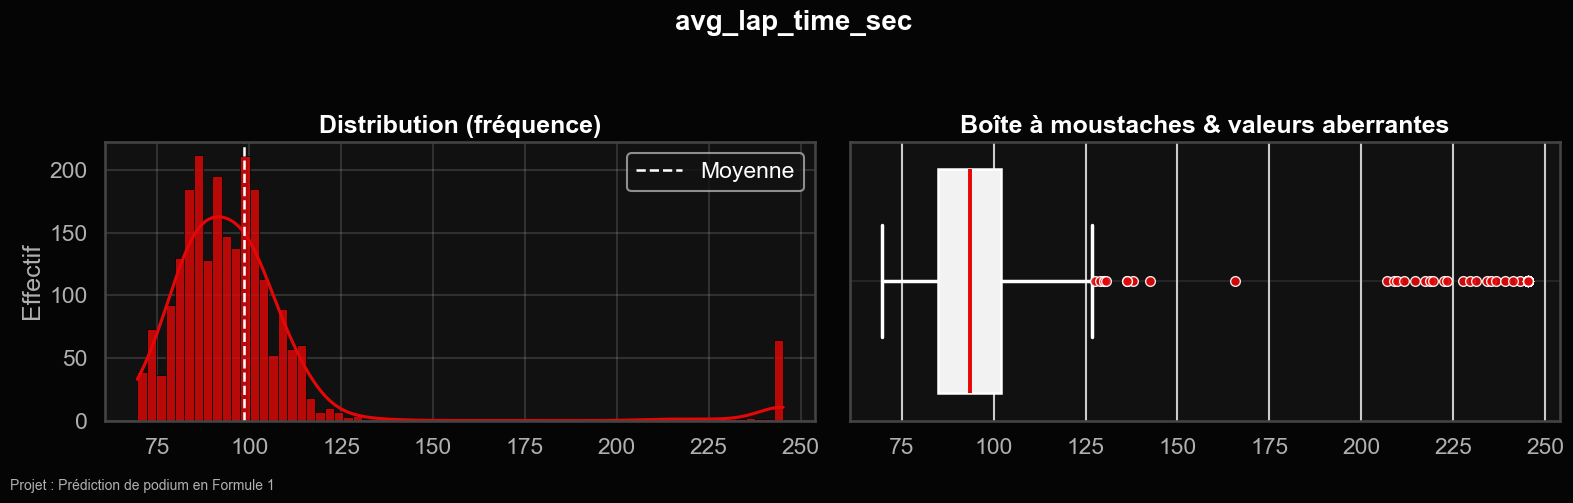

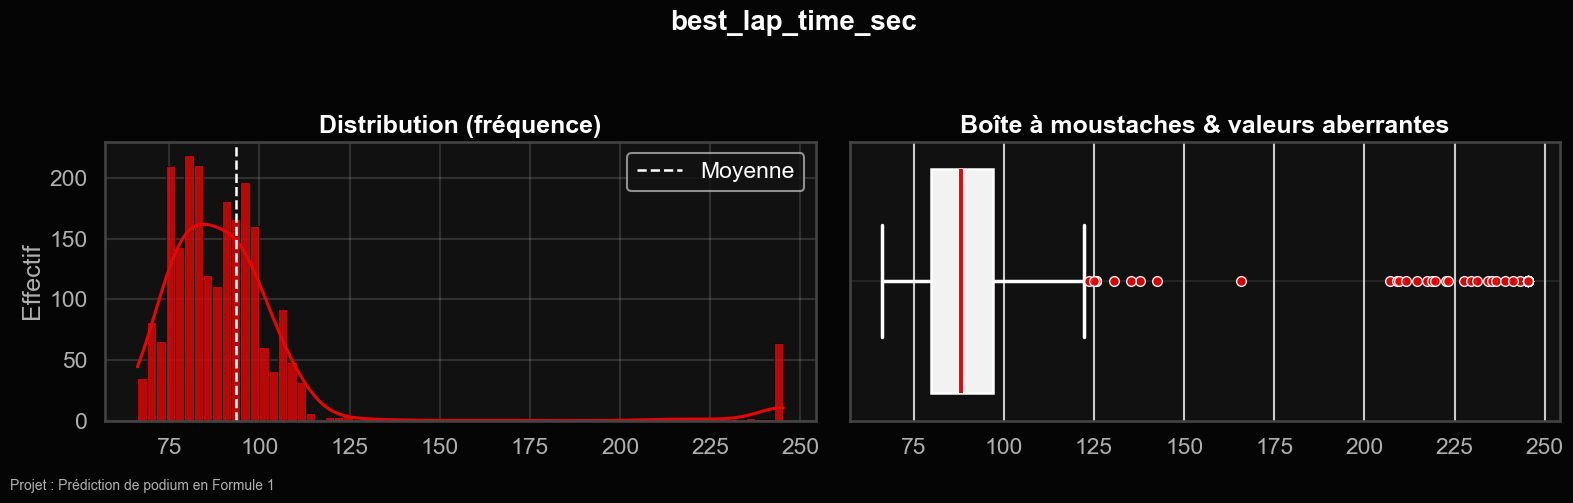

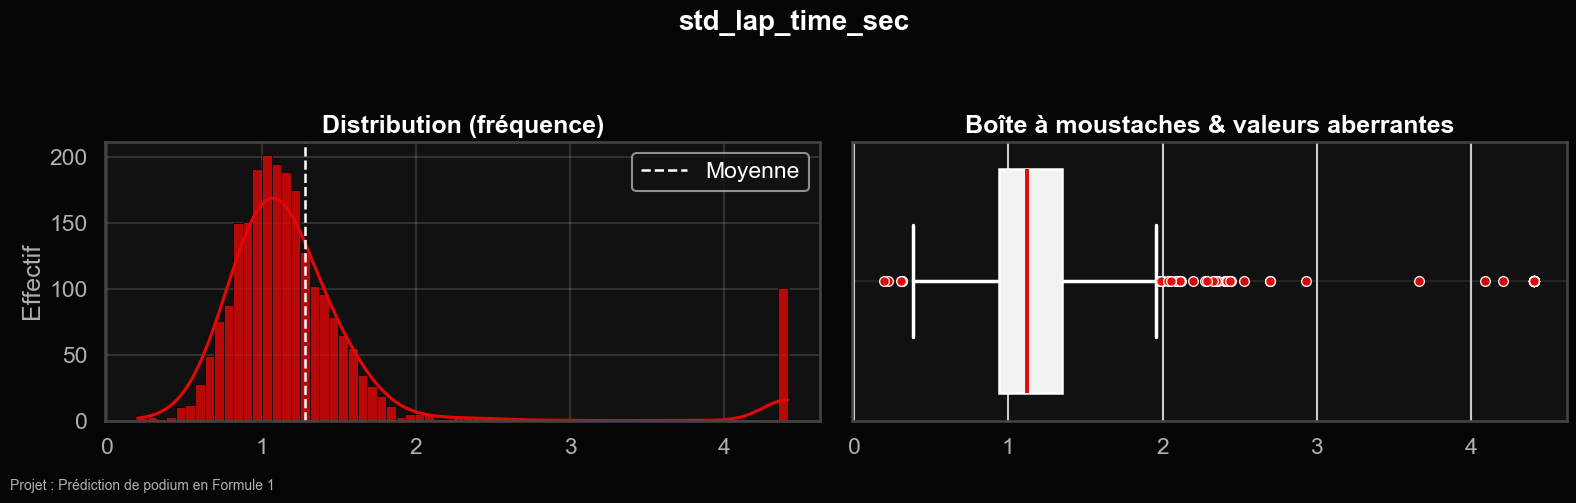

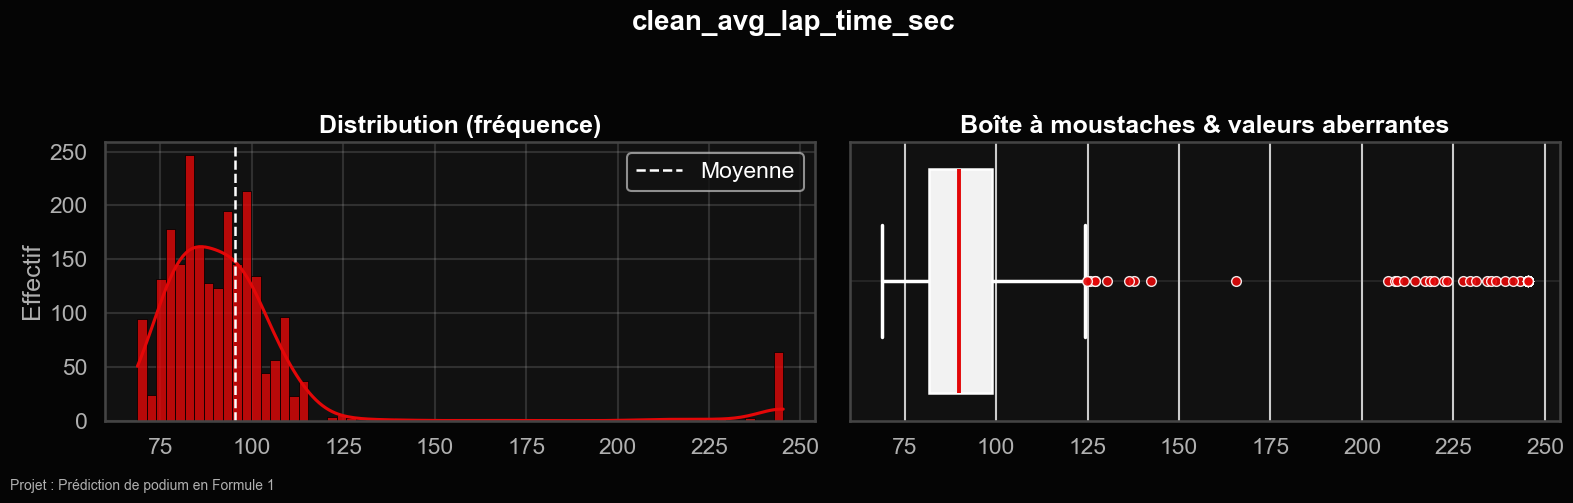

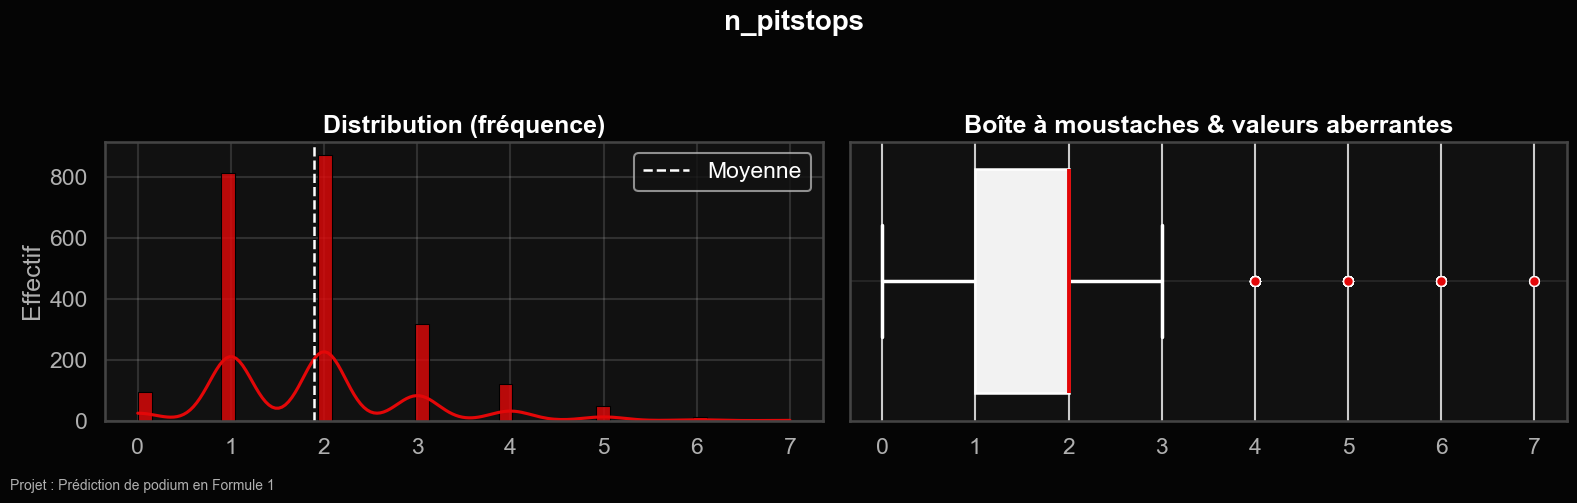

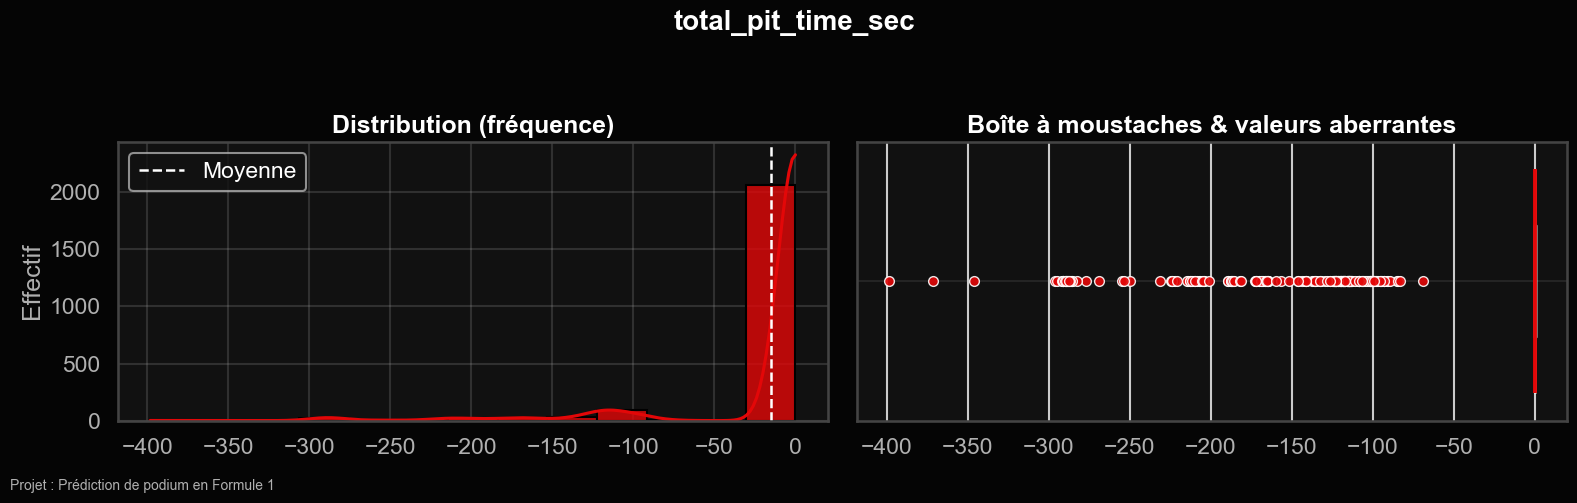

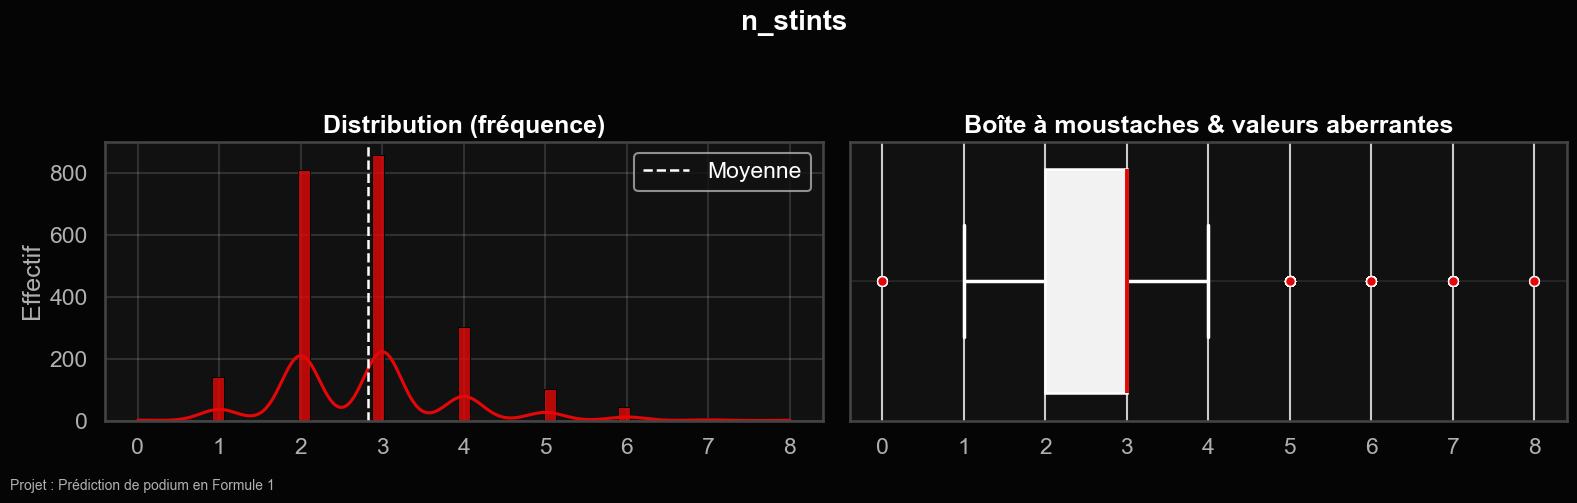

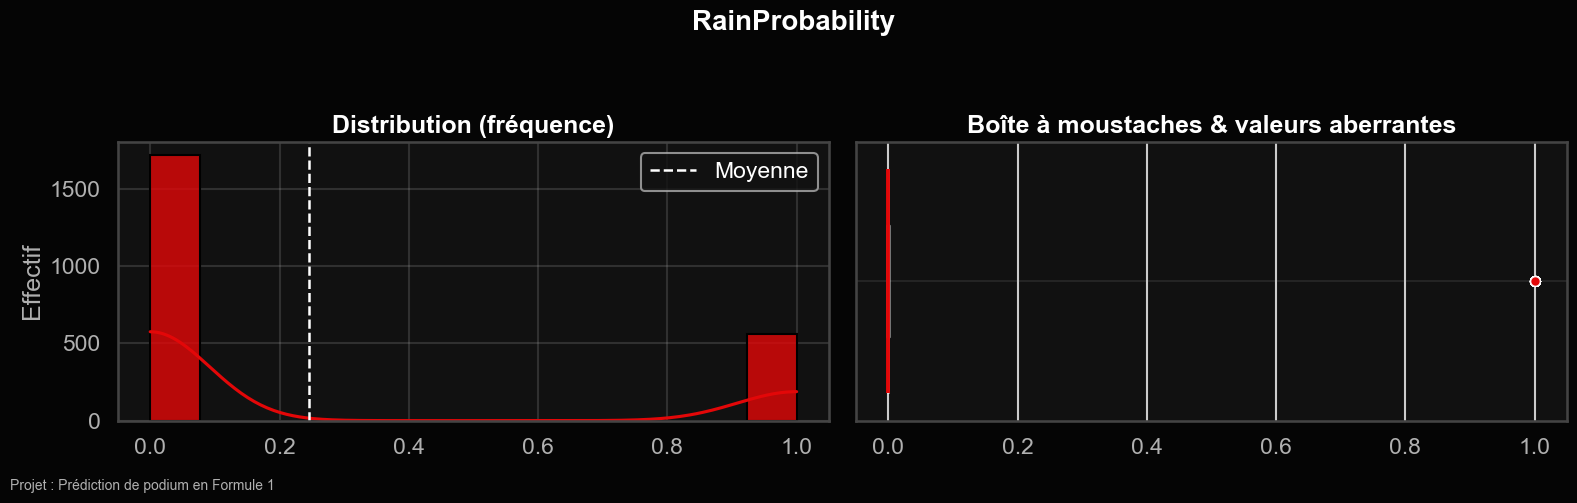

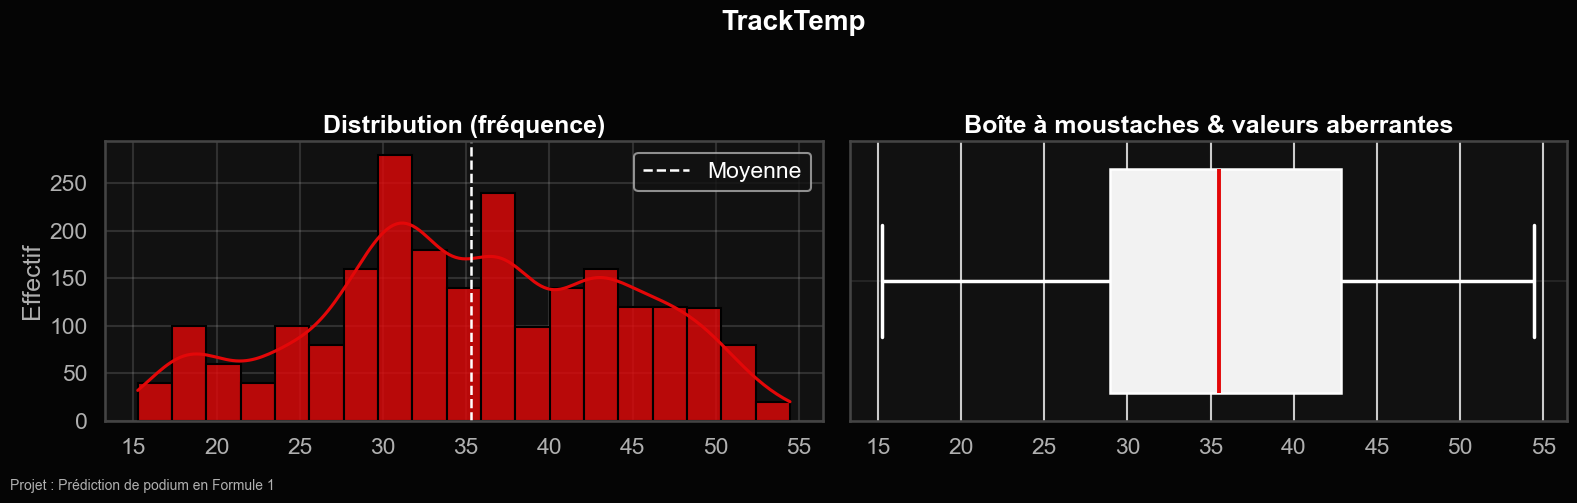

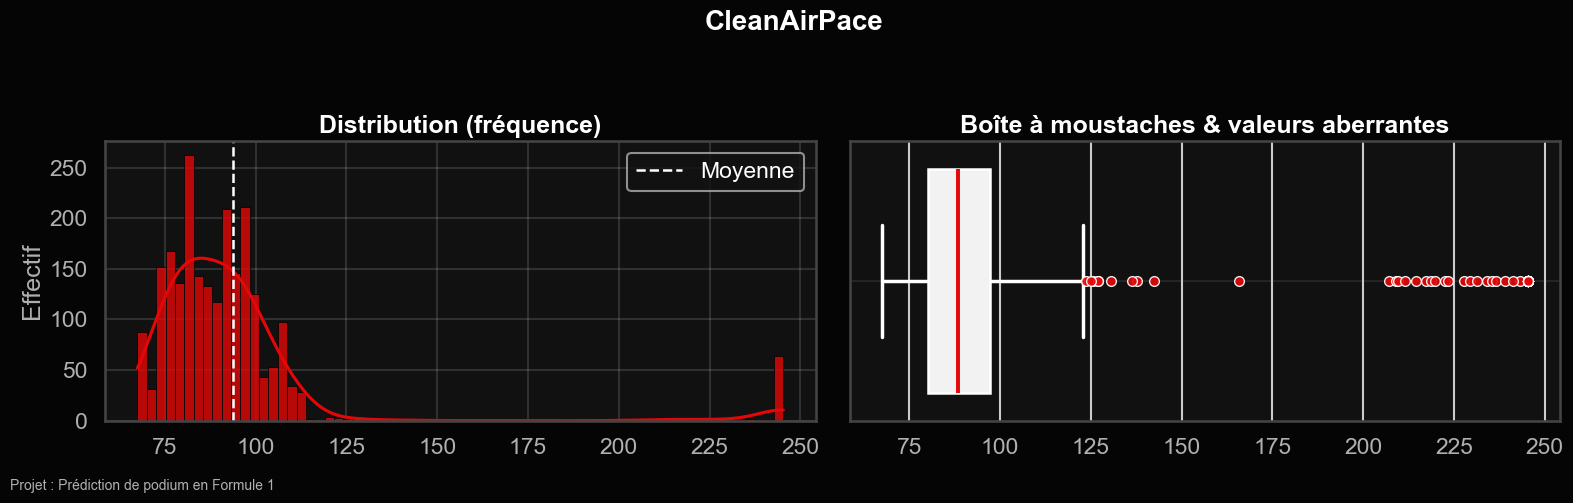

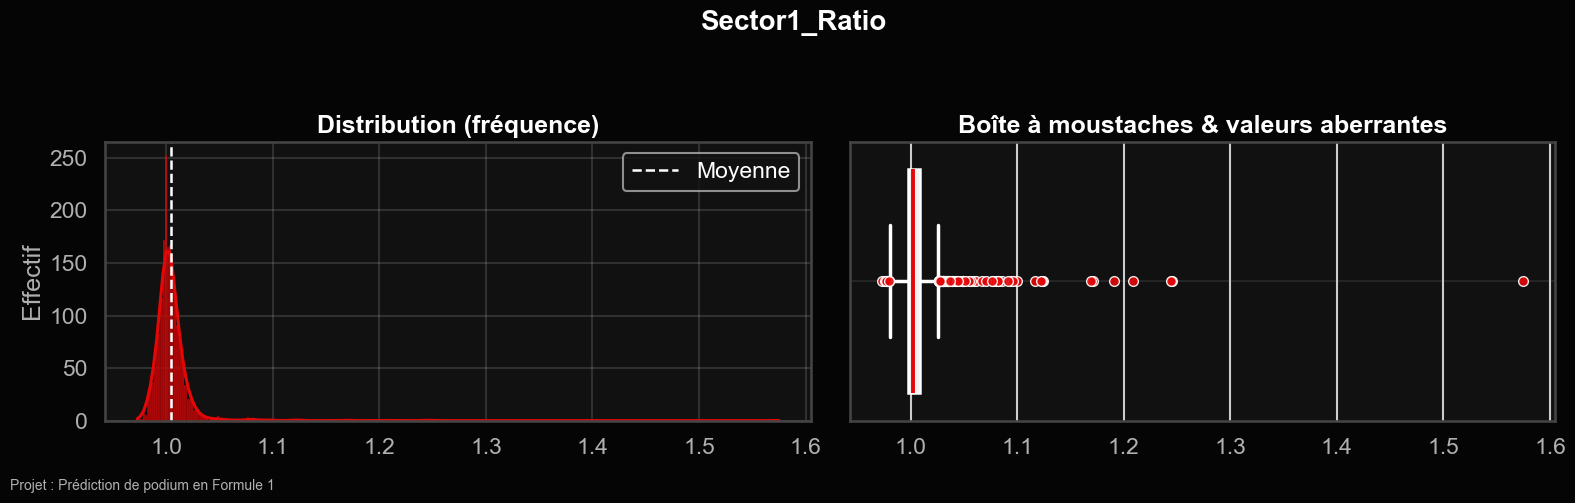

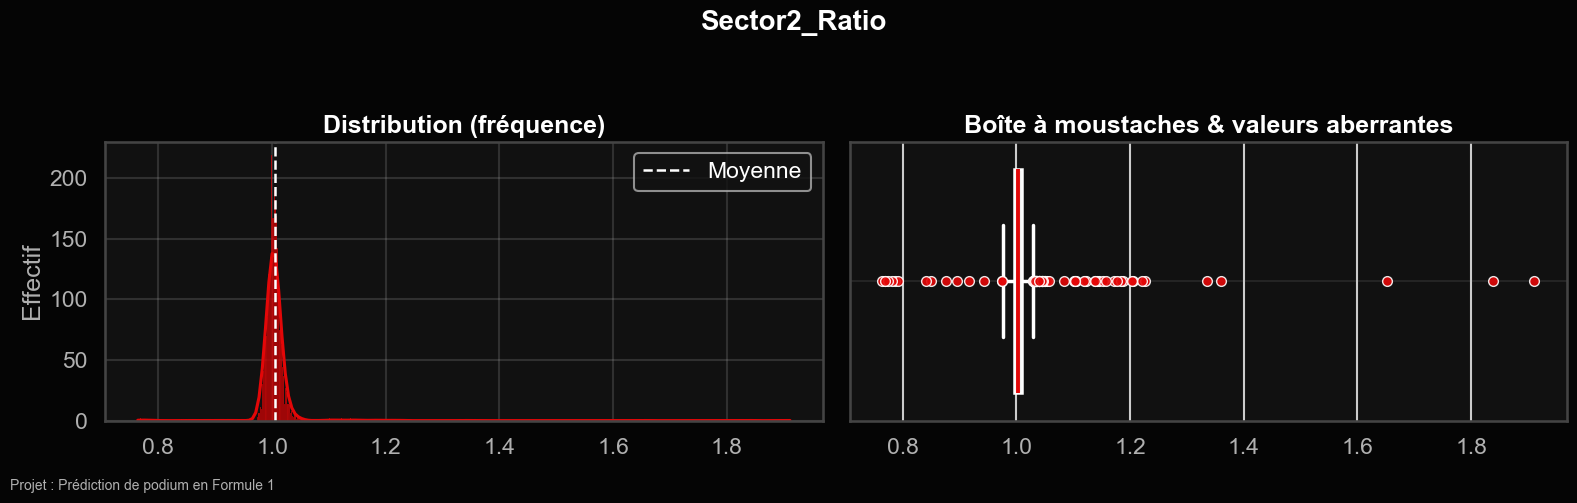

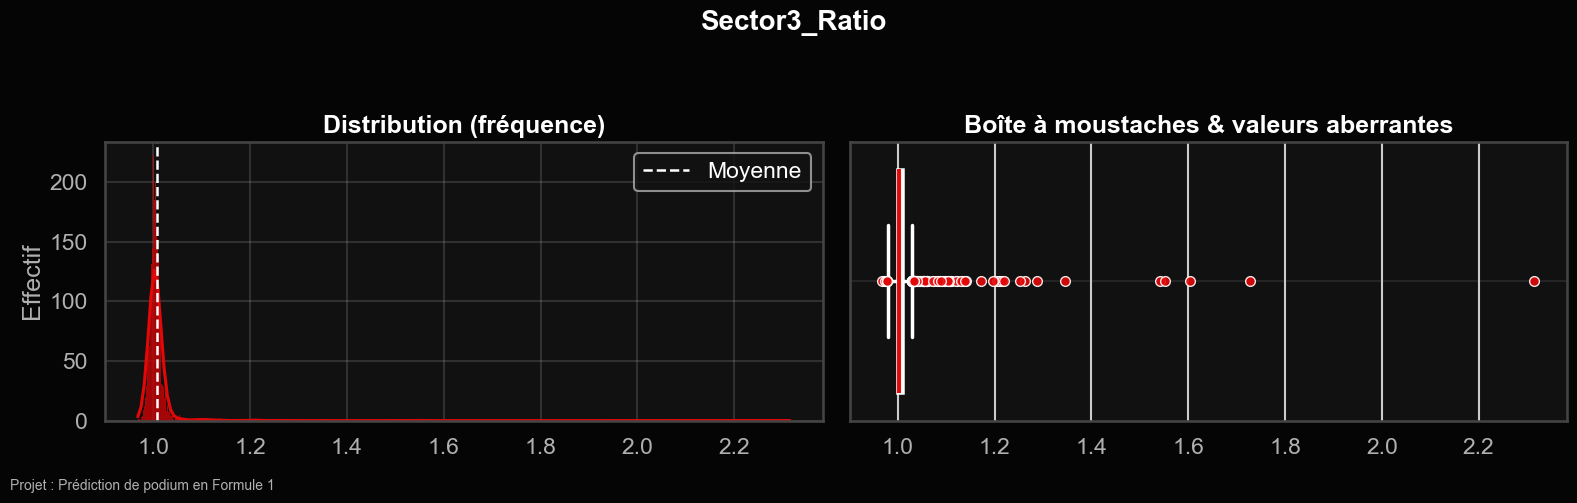

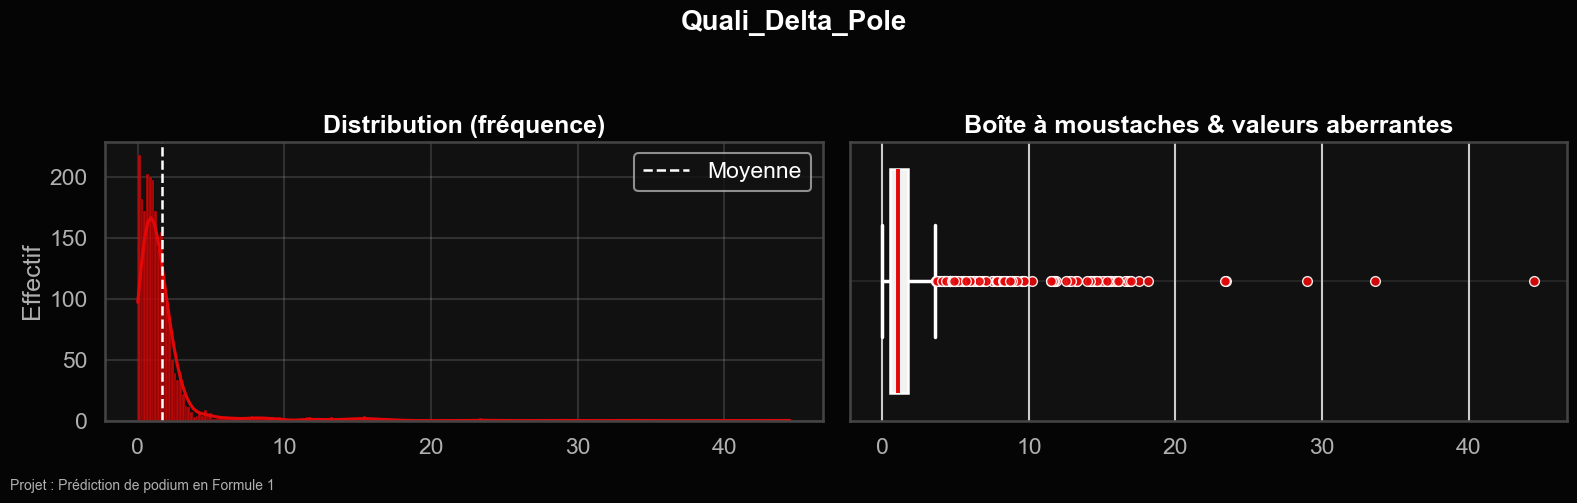

In [211]:
# Configuração Visual "Racing" - Estilo F1
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['font.family'] = 'sans-serif'

# Paleta F1
f1_red = '#e30708'        # Vermelho Ferrari / F1
carbon_black = '#050505'  # Preto mais profundo
track_grey = '#B0B0B0'    # Cinza pista

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_ignore = ['season', 'round', 'driver_number', 'driver_code']
numeric_cols = [c for c in numeric_cols if c not in cols_to_ignore]

print(f"--- Génération des graphiques style F1 pour {len(numeric_cols)} variables ---")

for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Fundo estilo "noite de GP"
    fig.patch.set_facecolor(carbon_black)
    for ax in axes:
        ax.set_facecolor('#111111')
    
    # Título Geral
    fig.suptitle(
        f'{col}',
        fontsize=20,
        weight='bold',
        color='white'
    )
    
    # 1. Histograma (Distribution)
    sns.histplot(
        data=df, x=col, kde=True, ax=axes[0],
        color=f1_red, edgecolor='black', alpha=0.8
    )
    
    mean_val = df[col].mean()
    axes[0].axvline(
        mean_val,
        color='white',
        linestyle='--',
        linewidth=1.8,
        label='Moyenne'
    )
    
    axes[0].set_title(
        'Distribution (fréquence)',
        color='white',
        weight='bold'
    )
    axes[0].set_ylabel('Effectif', color=track_grey)
    axes[0].set_xlabel('', color=track_grey)
    
    # Deixar ticks mais discretos
    axes[0].tick_params(colors=track_grey)
    axes[0].legend(facecolor='#111111', edgecolor=track_grey, labelcolor='white')
    axes[0].grid(alpha=0.2, color=track_grey)
    
    # 2. Boxplot (Boîte à moustaches) - MAIS CLARO

    sns.boxplot(
        data=df, x=col, ax=axes[1],
        color='#F2F2F2',        # Caixa ainda mais clara
        linewidth=1.8,

        boxprops=dict(
            edgecolor='white',
            linewidth=1.8
        ),

        whiskerprops=dict(      # <<< CAUDAS
            color='white',
            linewidth=2.5,
            linestyle='-'
        ),

        capprops=dict(          # <<< EXTREMIDADE DAS CAUDAS
            color='white',
            linewidth=2.5
        ),

        medianprops=dict(       # Mediana em vermelho F1
            color=f1_red,
            linewidth=2.8
        ),

        flierprops={            # Outliers
            "marker": "o",
            "markerfacecolor": f1_red,
            "markeredgecolor": "white",
            "markersize": 7,
            "alpha": 0.9
        }
    )

    axes[1].set_title(
        'Boîte à moustaches & valeurs aberrantes',
        color='white',
        weight='bold'
    )

    axes[1].set_xlabel('', color=track_grey)
    axes[1].tick_params(colors=track_grey)

    # Grade ultra sutil
    axes[1].grid(alpha=0.10, axis='y', color=track_grey)

    # Reforço de contraste do eixo
    for spine in axes[1].spines.values():
        spine.set_color('white')


    # Grade bem sutil
    axes[1].grid(alpha=0.12, axis='y', color=track_grey)

    # Remover bordas pesadas
    for ax in axes:
        for spine in ax.spines.values():
            spine.set_color('#444444')
    
    fig.text(
        0.01, 0.02,
        "Projet : Prédiction de podium en Formule 1",
        fontsize=10,
        color=track_grey
    )
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

#### Categorical columns

--- Génération des graphiques catégoriels style F1 pour 6 variables ---


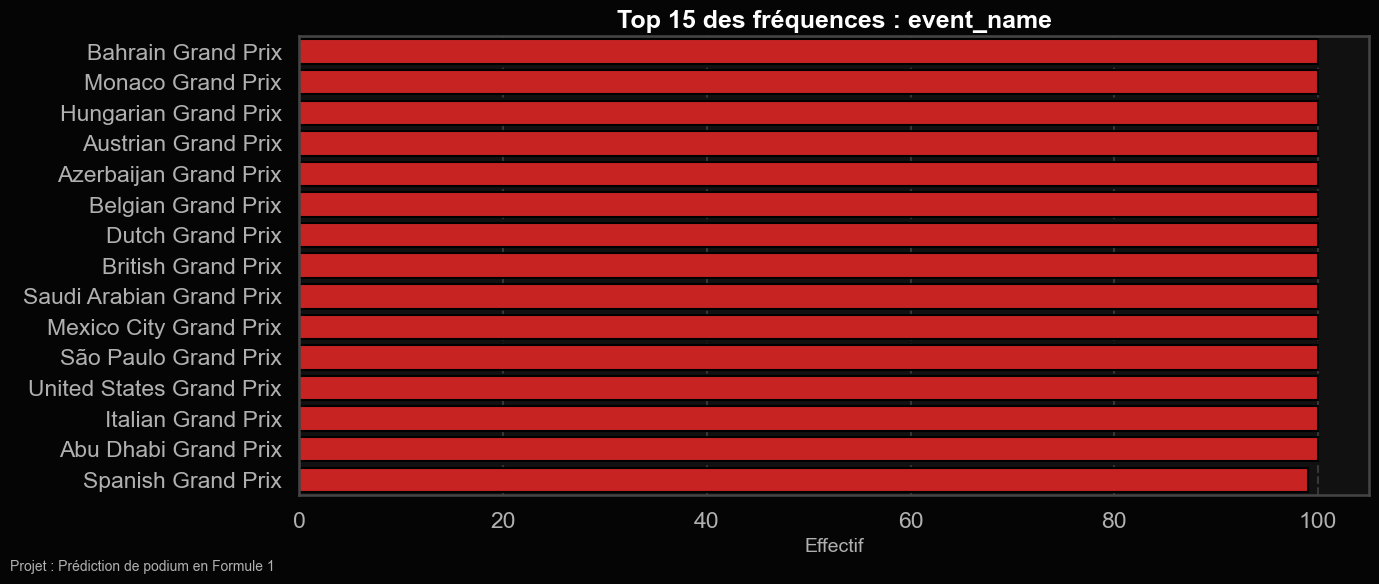

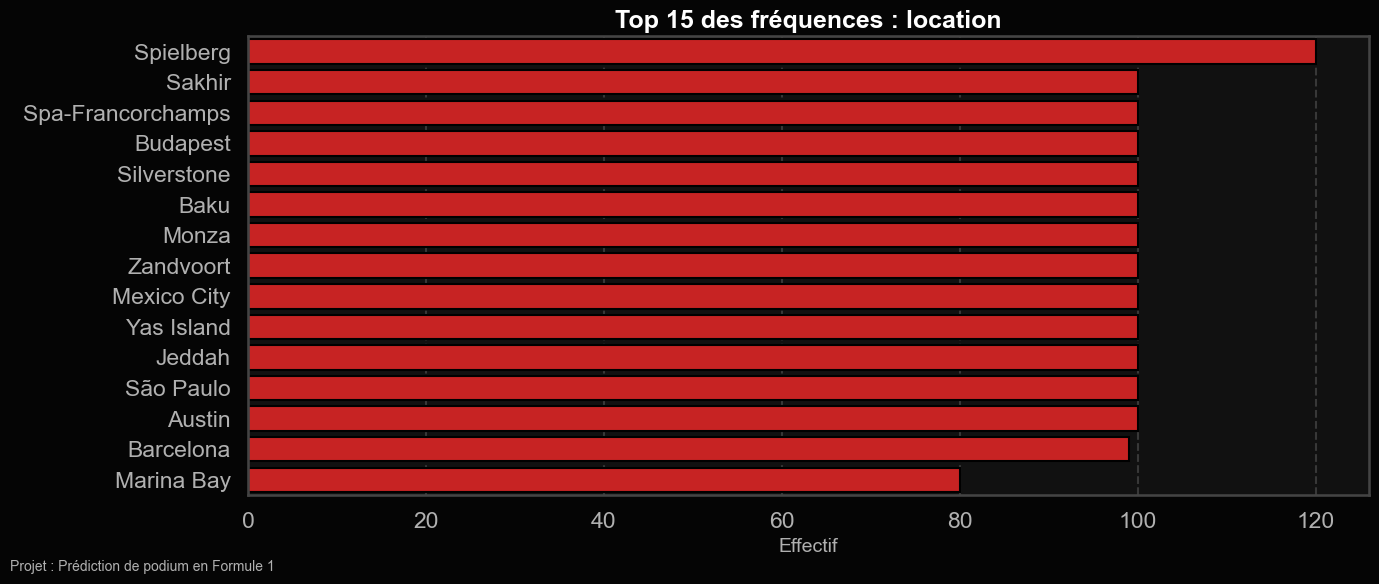

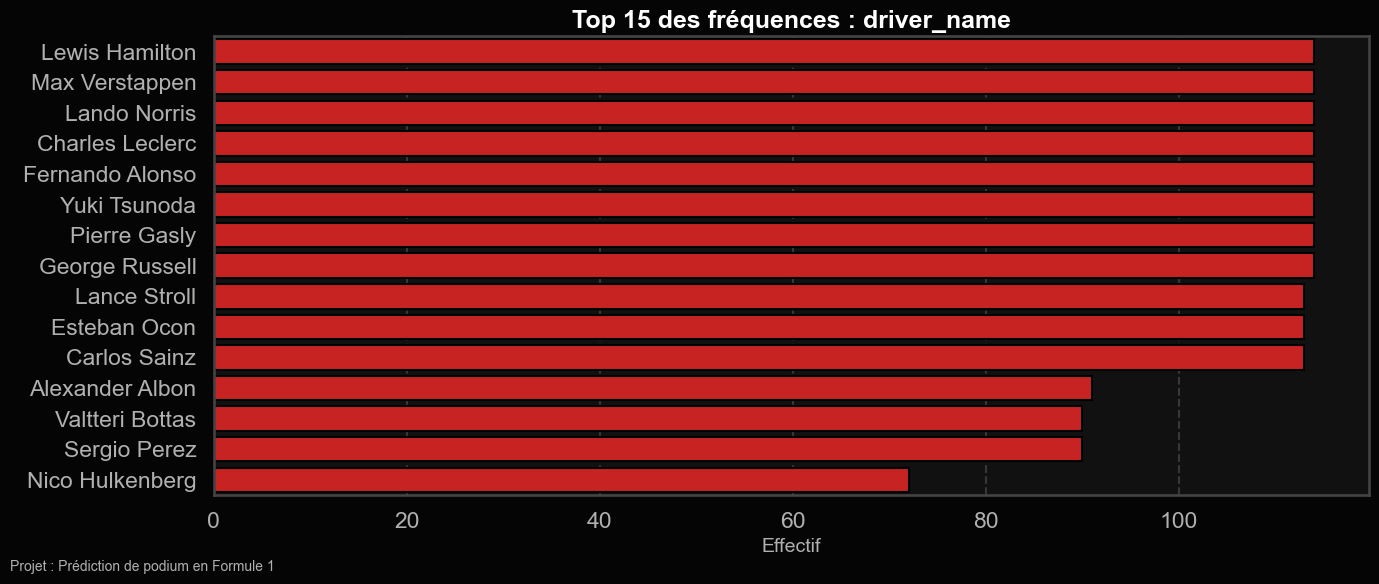

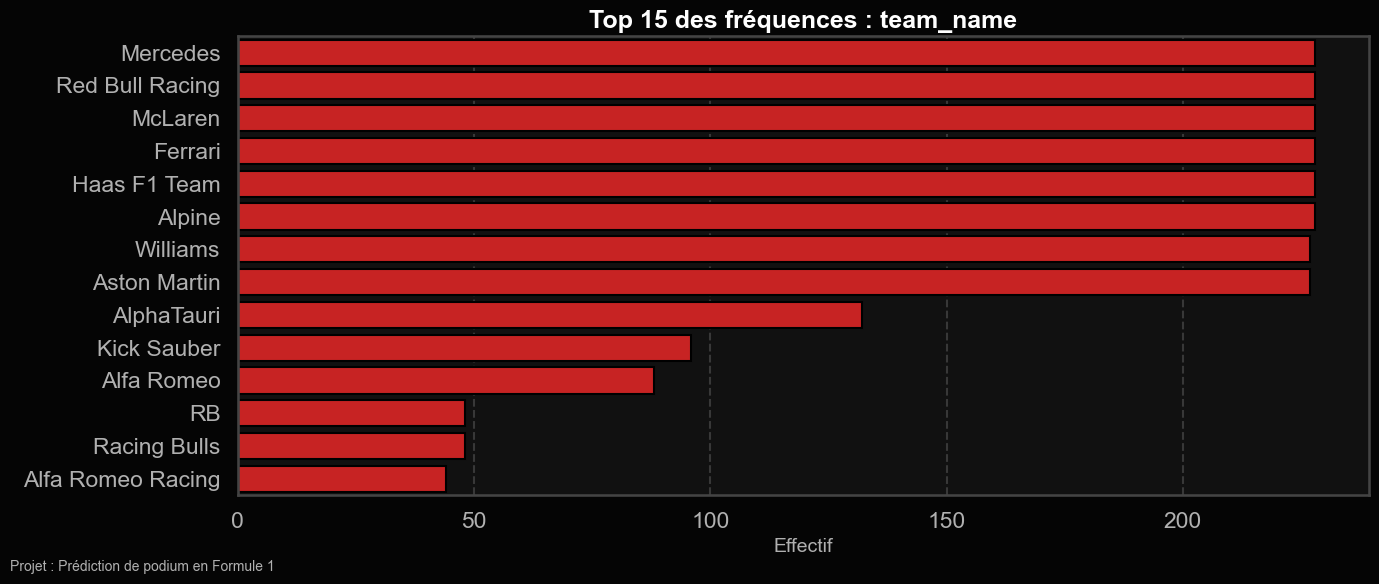

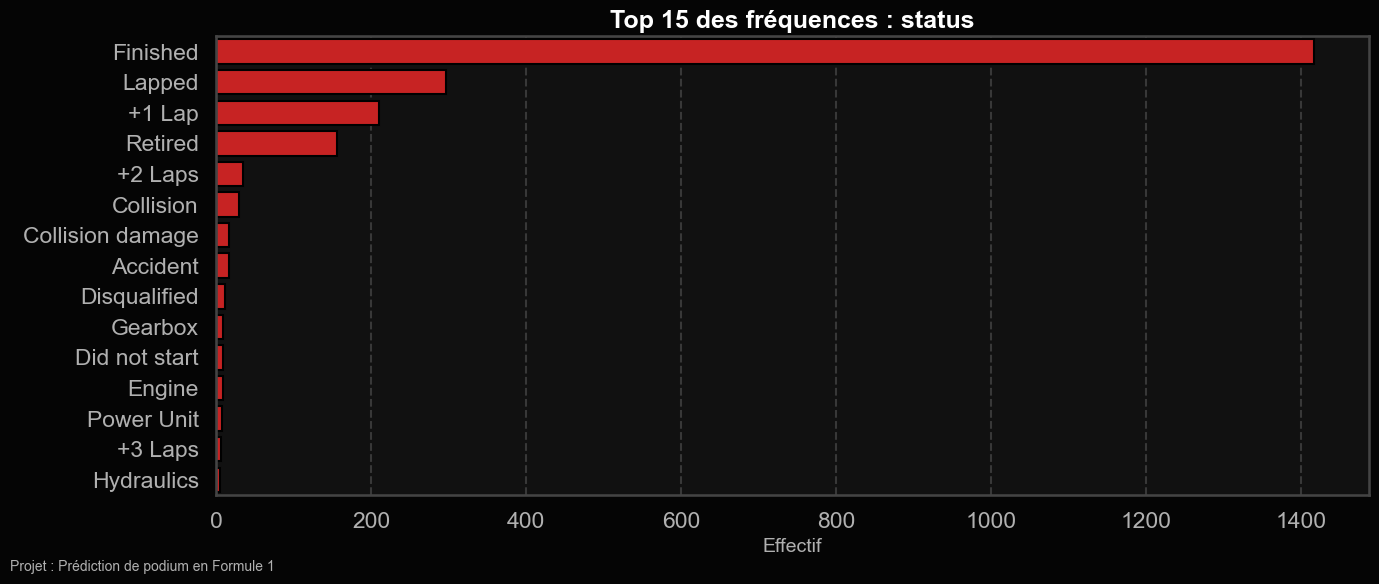

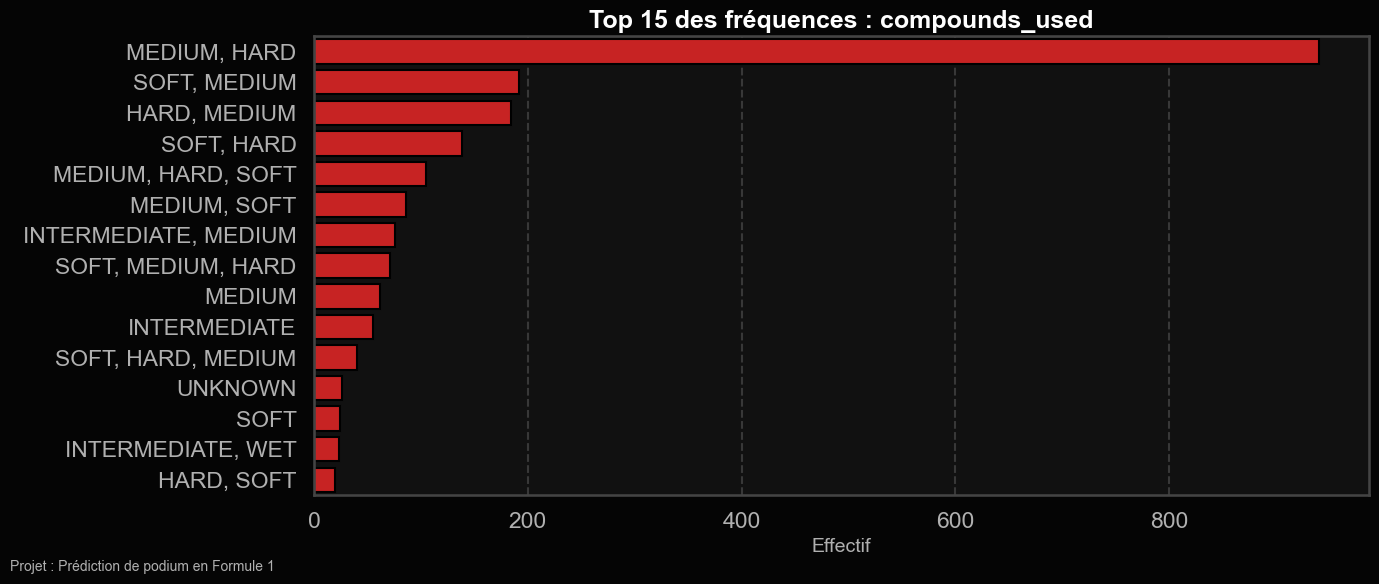

In [212]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c not in ['event_date', 'url']]

print(f"--- Génération des graphiques catégoriels style F1 pour {len(cat_cols)} variables ---")

for col in cat_cols:
    plt.figure(figsize=(14, 6))
    
    # Fundo estilo F1
    ax = plt.gca()
    plt.gcf().patch.set_facecolor(carbon_black)
    ax.set_facecolor('#111111')
    
    # Top 15 categorias
    top_counts = df[col].value_counts().head(15)
    
    sns.barplot(
        x=top_counts.values,
        y=top_counts.index,
        color=f1_red,          # Vermelho F1
        edgecolor='black'
    )
    
    # Título em FRANCÊS
    plt.title(
        f'Top 15 des fréquences : {col}',
        fontsize=18,
        weight='bold',
        color='white'
    )
    
    # Eixo X em francês
    plt.xlabel('Effectif', fontsize=14, color=track_grey)
    plt.ylabel('', color=track_grey)
    
    # Ticks visíveis no fundo escuro
    ax.tick_params(colors=track_grey)
    
    # Grade sutil no eixo X
    plt.grid(axis='x', linestyle='--', alpha=0.25, color=track_grey)
    
    # Bordas discretas
    for spine in ax.spines.values():
        spine.set_color('#444444')
    
    # Créditozinho do projeto
    plt.gcf().text(
        0.01, 0.02,
        "Projet : Prédiction de podium en Formule 1",
        fontsize=10,
        color=track_grey
    )
    
    plt.tight_layout()
    plt.show()


### Feature Engineering

As variáveis atuais capturadas dão uma noção da perfomance intra-corrida, sem olhar para o que ocorreu em corrida anterior 

In [213]:
grp_driver = df.groupby('driver_code')

In [214]:
# Criação da variável binária de pódio (Target)
df['podium'] = df['final_position'].apply(lambda x: 1 if x <= 3 else 0)

In [215]:
# Histórico de Pódios (Momentum)
# Quantas vezes o piloto subiu ao pódio nas últimas 5 corridas
# "Inércia de vitória" > pilotos em sequência positiva tendem a manter bom desempenho
df['podiums_last_5'] = df.groupby('driver_code')['podium'].transform(
    lambda x: x.shift(1).rolling(window=5).sum()
).fillna(0)

In [216]:
team_stats = df.groupby(['season', 'round', 'team_name'])['podium'].sum().reset_index()

# Calculamos a média móvel dos pódios da equipe nas últimas 5 corridas
# Atenção: Shift(1) para garantir que só usamos dados do PASSADO
team_stats['team_podium_rate_5'] = team_stats.groupby('team_name')['podium'].transform(
    lambda x: x.shift(1).rolling(window=5).mean()
).fillna(0)

# 2. MERGE COM O DATAFRAME PRINCIPAL
if 'team_podium_rate_5' not in df.columns:
    df = df.merge(team_stats[['season', 'round', 'team_name', 'team_podium_rate_5']], 
                  on=['season', 'round', 'team_name'], 
                  how='left')

In [217]:
# Média da posição final, com um peso exponencial
# Dá mais importância ao desempenho nas últimas 2 corridas que ao desempenho no início da temporada
# Permete detectar mudanças de ritmo
df['weighted_avg_pos'] = grp_driver['final_position'].transform(
    lambda x: x.ewm(span=5, adjust=False).mean().shift(1)
)

In [220]:
df.columns

Index(['season', 'round', 'event_name', 'location', 'event_date',
       'driver_code', 'driver_number', 'driver_name', 'team_name',
       'grid_position', 'final_position', 'status', 'points', 'total_time_sec',
       'laps_completed', 'avg_lap_time_sec', 'best_lap_time_sec',
       'std_lap_time_sec', 'clean_avg_lap_time_sec', 'n_pitstops',
       'total_pit_time_sec', 'n_stints', 'compounds_used', 'RainProbability',
       'TrackTemp', 'CleanAirPace', 'Sector1_Ratio', 'Sector2_Ratio',
       'Sector3_Ratio', 'Quali_Delta_Pole', 'podium', 'podiums_last_5',
       'team_podium_rate_5', 'weighted_avg_pos', 'pos_gain_raw'],
      dtype='object')

In [221]:
# 1. Ganho na corrida individual 
df['pos_gain_raw'] = df['grid_position'] - df['final_position']

# 2. Média histórica (perfil)
df['avg_racecraft'] = df.groupby('driver_code')['pos_gain_raw'].transform(
    lambda x: x.rolling(window=10, min_periods=3).mean().shift(1)
)
# Preencher pilotos novos com 0 (neutro)
df['avg_racecraft'] = df['avg_racecraft'].fillna(0)

In [223]:
# Reliability Rate
valid_finish = ['Finished', '+1 Lap', '+2 Laps', '+3 Laps']
df['is_finished'] = df['status'].apply(lambda x: 1 if str(x) in valid_finish else 0)

df['reliability_rate'] = df.groupby('driver_code')['is_finished'].transform(
    lambda x: x.rolling(window=15, min_periods=5).mean().shift(1)
)
df['reliability_rate'] = df['reliability_rate'].fillna(0.8) # Assumimos 80% de confiabilidade inicial

In [224]:
# Especialista de pista
# Média histórica da posição final do piloto em um circuito específico em anos anteriores
# Afinidade do piloto com o track
# Se o piloto nunca correu na pista, é preenchido com a média ponderada geral
df['track_avg_pos'] = df.groupby(['driver_code', 'event_name'])['final_position'].transform(
  lambda x: x.expanding().mean().shift(1)
)
# Fallback: Se nunca correu na pista, usa a média ponderada atual
df['track_avg_pos'] = df['track_avg_pos'].fillna(df['weighted_avg_pos'])

In [225]:
# FEATURE: clean_air_pace
# Lógica: Média das 5 voltas mais rápidas do piloto na corrida.
# Isso isola a performance pura do carro, ignorando voltas lentas (box/tráfego).
# Importante: Como não temos a telemetria bruta aqui, vamos usar uma aproximação
# baseada na 'fastest_lap_time_sec' e 'avg_lap_time_sec' que já temos.

# Aproximação: (Volta Mais Rápida + Média Geral) / 2
# (Em um script ideal, usaríamos a média das Top 5 voltas reais, mas isso requer dados volta a volta)
df['clean_air_pace_raw'] = (df['best_lap_time_sec'] + df['clean_avg_lap_time_sec']) / 2

# Agora aplicamos o SHIFT para usar o dado da corrida ANTERIOR
df['clean_air_pace_last'] = df.groupby('driver_code')['clean_air_pace_raw'].transform(
    lambda x: x.shift(1).rolling(window=3).mean()
)

# Se não tiver histórico, usa a média da temporada
season_mean_pace = df.groupby('season')['clean_air_pace_raw'].transform('mean')
df['clean_air_pace_last'] = df['clean_air_pace_last'].fillna(season_mean_pace)

In [226]:
# --- Célula 8: Delta de Classificação (Quali Performance) ---

# FEATURE: quali_delta
# Lógica: Quão longe da Pole Position (1º no Grid) o piloto largou?
# Como não temos o tempo exato da pole em segundos neste dataset, 
# usamos a Posição de Largada como proxy, mas normalizada.

# Normalização: (Grid - 1) / 20. 
# 0.0 = Pole Position (Melhor)
# 1.0 = Último Lugar (Pior)
df['quali_deficit_score'] = (df['grid_position'] - 1) / 19.0

# Média histórica desse déficit (Mostra se o piloto é bom classificador)
df['avg_quali_deficit'] = df.groupby('driver_code')['quali_deficit_score'].transform(
    lambda x: x.rolling(window=10, min_periods=3).mean().shift(1)
)

df['avg_quali_deficit'] = df['avg_quali_deficit'].fillna(0.5) # Valor médio para novatos

In [227]:
# --- Célula 9: Especialista de Pista (Track Specialist) ---

# FEATURE: track_avg_pos
# Lógica: Média histórica do piloto NESTA pista específica.
# Importante para capturar "Fator Casa" ou pilotos especialistas em rua (Mônaco/Baku).

# Usamos expanding().mean() para pegar todo o histórico disponível até a data
df['track_avg_pos'] = df.groupby(['driver_code', 'event_name'])['final_position'].transform(
    lambda x: x.shift(1).expanding().mean()
)

# Se o piloto nunca correu nesta pista (NaN), usamos a sua média ponderada geral como "chute"
df['track_avg_pos'] = df['track_avg_pos'].fillna(df['weighted_avg_pos'])


### EDA

In [228]:
df.head()

,season,round,event_name,location,event_date,driver_code,driver_number,driver_name,team_name,grid_position,...,weighted_avg_pos,pos_gain_raw,avg_racecraft,is_finished,reliability_rate,track_avg_pos,clean_air_pace_raw,clean_air_pace_last,quali_deficit_score,avg_quali_deficit
0,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,44,44,Lewis Hamilton,Mercedes,2.0,...,NaN,1.0,0.0,1,0.8,NaN,94.606684,98.297601,0.052632,0.5
1,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,33,33,Max Verstappen,Red Bull Racing,1.0,...,NaN,-1.0,0.0,1,0.8,NaN,94.247153,98.297601,0.000000,0.5
2,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,77,77,Valtteri Bottas,Mercedes,3.0,...,NaN,0.0,0.0,1,0.8,NaN,93.663766,98.297601,0.105263,0.5
3,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,4,4,Lando Norris,McLaren,7.0,...,NaN,3.0,0.0,1,0.8,NaN,95.199204,98.297601,0.315789,0.5
4,2021,1,Bahrain Grand Prix,Sakhir,2021-03-28,11,11,Sergio Perez,Red Bull Racing,0.0,...,NaN,-5.0,0.0,1,0.8,NaN,94.985950,98.297601,-0.052632,0.5


In [229]:
df.tail(20)

,season,round,event_name,location,event_date,driver_code,driver_number,driver_name,team_name,grid_position,...,weighted_avg_pos,pos_gain_raw,avg_racecraft,is_finished,reliability_rate,track_avg_pos,clean_air_pace_raw,clean_air_pace_last,quali_deficit_score,avg_quali_deficit
2258,2025,24,Abu Dhabi Grand Prix,Yas Island,2025-12-07,1,1,Max Verstappen,Red Bull Racing,1.0,...,1.713295,0.0,2.1,1,0.933333,2.666667,88.185710,84.009486,0.000000,0.184211
2259,2025,24,Abu Dhabi Grand Prix,Yas Island,2025-12-07,81,81,Oscar Piastri,McLaren,3.0,...,7.557145,1.0,-2.6,1,0.866667,8.000000,87.835982,84.130176,0.105263,0.163158
2260,2025,24,Abu Dhabi Grand Prix,Yas Island,2025-12-07,4,4,Lando Norris,McLaren,2.0,...,6.608181,-1.0,-3.2,1,0.800000,4.750000,87.695400,84.217398,0.052632,0.084211
2261,2025,24,Abu Dhabi Grand Prix,Yas Island,2025-12-07,16,16,Charles Leclerc,Ferrari,5.0,...,7.753458,1.0,-2.3,1,0.866667,4.250000,87.705509,86.691329,0.210526,0.236842
2262,2025,24,Abu Dhabi Grand Prix,Yas Island,2025-12-07,63,63,George Russell,Mercedes,4.0,...,4.503610,-1.0,0.2,1,1.000000,7.750000,89.041696,84.589370,0.157895,0.168421
2263,2025,24,Abu Dhabi Grand Prix,Yas Island,2025-12-07,14,14,Fernando Alonso,Aston Martin,6.0,...,10.759324,0.0,-2.0,1,0.800000,11.000000,89.039526,85.187662,0.263158,0.442105
2264,2025,24,Abu Dhabi Grand Prix,Yas Island,2025-12-07,31,31,Esteban Ocon,Haas F1 Team,8.0,...,12.639705,1.0,3.1,1,0.600000,9.333333,89.242446,85.241402,0.368421,0.810526
2265,2025,24,Abu Dhabi Grand Prix,Yas Island,2025-12-07,44,44,Lewis Hamilton,Ferrari,16.0,...,10.661639,8.0,0.0,1,0.800000,8.250000,88.806909,85.305142,0.789474,0.494737
2266,2025,24,Abu Dhabi Grand Prix,Yas Island,2025-12-07,27,27,Nico Hulkenberg,Kick Sauber,18.0,...,14.146760,9.0,-1.5,1,0.600000,11.500000,88.340255,86.032446,0.894737,0.636842
2267,2025,24,Abu Dhabi Grand Prix,Yas Island,2025-12-07,18,18,Lance Stroll,Aston Martin,15.0,...,16.006189,5.0,1.3,1,0.466667,11.250000,88.749651,134.779141,0.736842,0.747368


In [230]:
df.columns

Index(['season', 'round', 'event_name', 'location', 'event_date',
       'driver_code', 'driver_number', 'driver_name', 'team_name',
       'grid_position', 'final_position', 'status', 'points', 'total_time_sec',
       'laps_completed', 'avg_lap_time_sec', 'best_lap_time_sec',
       'std_lap_time_sec', 'clean_avg_lap_time_sec', 'n_pitstops',
       'total_pit_time_sec', 'n_stints', 'compounds_used', 'RainProbability',
       'TrackTemp', 'CleanAirPace', 'Sector1_Ratio', 'Sector2_Ratio',
       'Sector3_Ratio', 'Quali_Delta_Pole', 'podium', 'podiums_last_5',
       'team_podium_rate_5', 'weighted_avg_pos', 'pos_gain_raw',
       'avg_racecraft', 'is_finished', 'reliability_rate', 'track_avg_pos',
       'clean_air_pace_raw', 'clean_air_pace_last', 'quali_deficit_score',
       'avg_quali_deficit'],
      dtype='object')

C:\Users\thzli\AppData\Local\Temp\ipykernel_5404\268528763.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


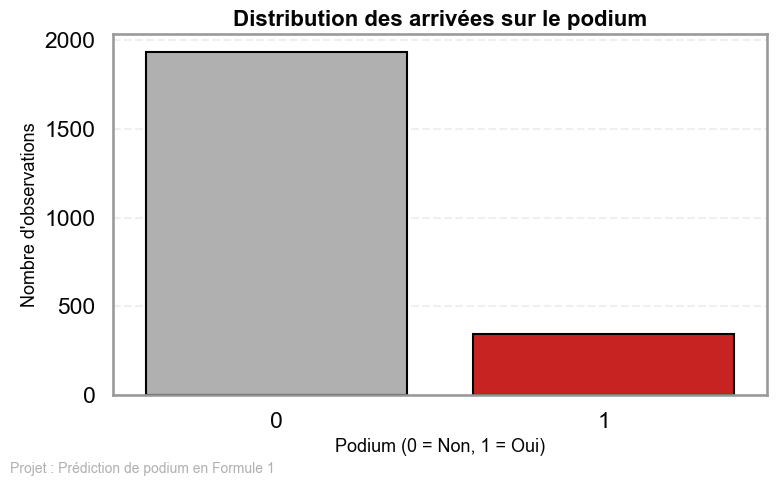

In [233]:
plt.figure(figsize=(8, 5))
ax = plt.gca()

# --- FUNDO BRANCO GARANTIDO ---
plt.gcf().patch.set_facecolor('white')
ax.set_facecolor('white')

sns.countplot(
    x='podium',
    data=df,
    palette=[track_grey, f1_red],  # 0 = cinza, 1 = vermelho F1
    edgecolor='black'
)

# --- TÍTULOS EM FRANCÊS ---
plt.title(
    "Distribution des arrivées sur le podium",
    fontsize=16,
    weight='bold',
    color=carbon_black
)

plt.xlabel("Podium (0 = Non, 1 = Oui)", fontsize=13, color=carbon_black)
plt.ylabel("Nombre d'observations", fontsize=13, color=carbon_black)

# --- Ticks legíveis ---
ax.tick_params(colors=carbon_black)

# --- Grade sutil ---
plt.grid(axis='y', linestyle='--', alpha=0.3)

# --- Bordas discretas ---
for spine in ax.spines.values():
    spine.set_color('#999999')

# --- Crédito científico discreto ---
plt.gcf().text(
    0.02, 0.02,
    "Projet : Prédiction de podium en Formule 1",
    fontsize=10,
    color=track_grey
)

plt.tight_layout()
plt.show()


Classes desbalanceadas, na implementação do modelo precisam-se trabalhar estratégias para contornar o problema.

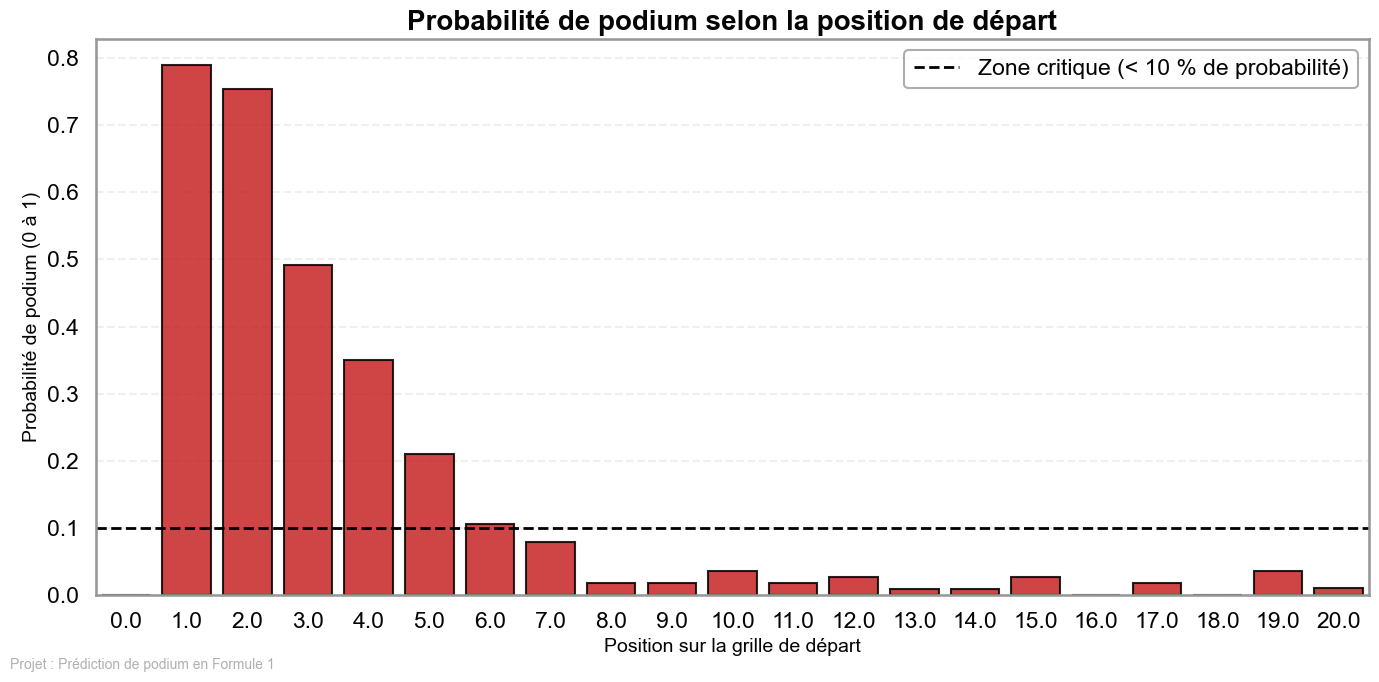

In [234]:
plt.figure(figsize=(14, 7))
ax = plt.gca()

# --- FUNDO BRANCO GARANTIDO ---
plt.gcf().patch.set_facecolor('white')
ax.set_facecolor('white')

# --- Cálculo da probabilidade de pódio por grid ---
grid_prob = df.groupby('grid_position')['podium'].mean().reset_index()
grid_prob = grid_prob[grid_prob['grid_position'] <= 20]

# --- Gráfico de barras (vermelho F1) ---
sns.barplot(
    x='grid_position',
    y='podium',
    data=grid_prob,
    color=f1_red,
    alpha=0.85,
    edgecolor='black'
)

plt.axhline(
    y=0.10,
    color='black',
    linestyle='--',
    linewidth=2,
    label="Zone critique (< 10 % de probabilité)"
)

plt.title(
    "Probabilité de podium selon la position de départ",
    fontsize=20,
    weight='bold',
    color=carbon_black
)

plt.xlabel("Position sur la grille de départ", fontsize=14, color=carbon_black)
plt.ylabel("Probabilité de podium (0 à 1)", fontsize=14, color=carbon_black)

ax.tick_params(colors=carbon_black)

plt.grid(axis='y', linestyle='--', alpha=0.3)

for spine in ax.spines.values():
    spine.set_color('#999999')

legend = plt.legend(frameon=True, edgecolor='#999999')
for text in legend.get_texts():
    text.set_color(carbon_black)

plt.gcf().text(
    0.01, 0.02,
    "Projet : Prédiction de podium en Formule 1",
    fontsize=10,
    color=track_grey
)

plt.tight_layout()
plt.show()

Largar abaixo de P8 torna rara a possibilidade de pódio

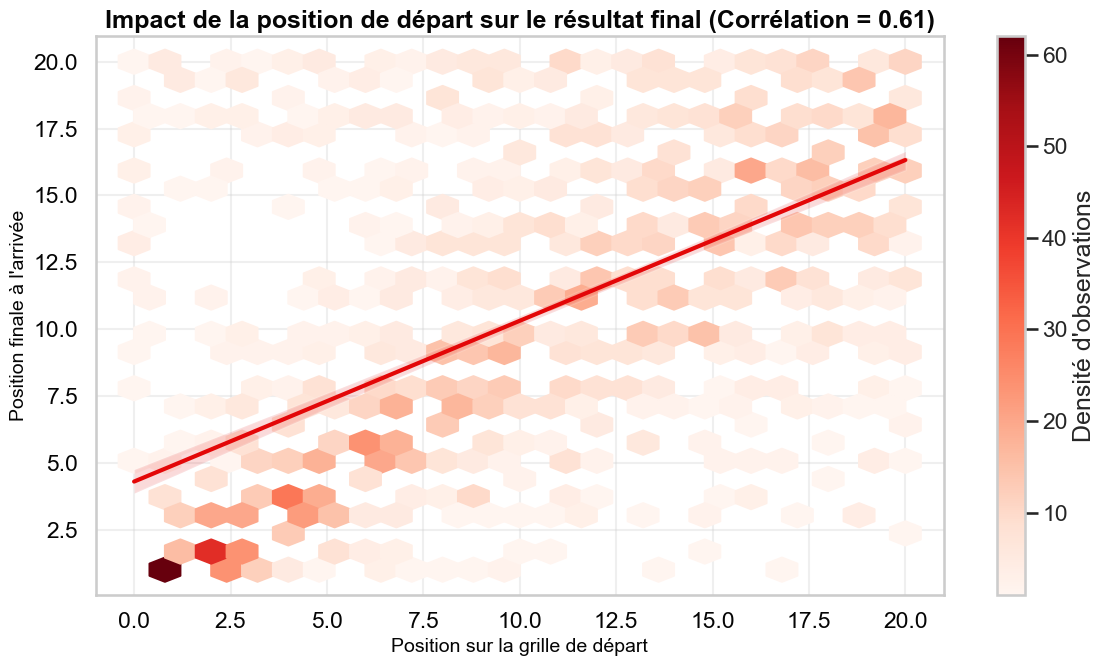

In [237]:
# --- Corrélation Grille de départ vs Position finale ---
corr = df['grid_position'].corr(df['final_position'])

plt.figure(figsize=(12, 7))
ax = plt.gca()

# HEXBIN para evitar sobreposição
hb = plt.hexbin(
    df['grid_position'],
    df['final_position'],
    gridsize=25,
    cmap='Reds',
    mincnt=1
)

cb = plt.colorbar(hb)
cb.set_label("Densité d'observations")

# Linha de tendência
sns.regplot(
    x='grid_position',
    y='final_position',
    data=df,
    scatter=False,
    line_kws={'color': f1_red, 'linewidth': 3}
)

# TÍTULOS EM FRANCÊS
plt.title(
    f"Impact de la position de départ sur le résultat final (Corrélation = {corr:.2f})",
    fontsize=18,
    weight='bold',
    color=carbon_black
)

plt.xlabel("Position sur la grille de départ", fontsize=14, color=carbon_black)
plt.ylabel("Position finale à l'arrivée", fontsize=14, color=carbon_black)

ax.tick_params(colors=carbon_black)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Pilotos que fazem pódio (amarelo) têm uma média ponderada mais baixa e estão se saindo melhor nas corridas em comparação com quem não faz pódio (cinza)

Isso significa que os pilotos que fazem pódio têm uma média ponderada mais baixa, estão se saindo melhor nas corridas

In [239]:
df.columns

Index(['season', 'round', 'event_name', 'location', 'event_date',
       'driver_code', 'driver_number', 'driver_name', 'team_name',
       'grid_position', 'final_position', 'status', 'points', 'total_time_sec',
       'laps_completed', 'avg_lap_time_sec', 'best_lap_time_sec',
       'std_lap_time_sec', 'clean_avg_lap_time_sec', 'n_pitstops',
       'total_pit_time_sec', 'n_stints', 'compounds_used', 'RainProbability',
       'TrackTemp', 'CleanAirPace', 'Sector1_Ratio', 'Sector2_Ratio',
       'Sector3_Ratio', 'Quali_Delta_Pole', 'podium', 'podiums_last_5',
       'team_podium_rate_5', 'weighted_avg_pos', 'pos_gain_raw',
       'avg_racecraft', 'is_finished', 'reliability_rate', 'track_avg_pos',
       'clean_air_pace_raw', 'clean_air_pace_last', 'quali_deficit_score',
       'avg_quali_deficit'],
      dtype='object')

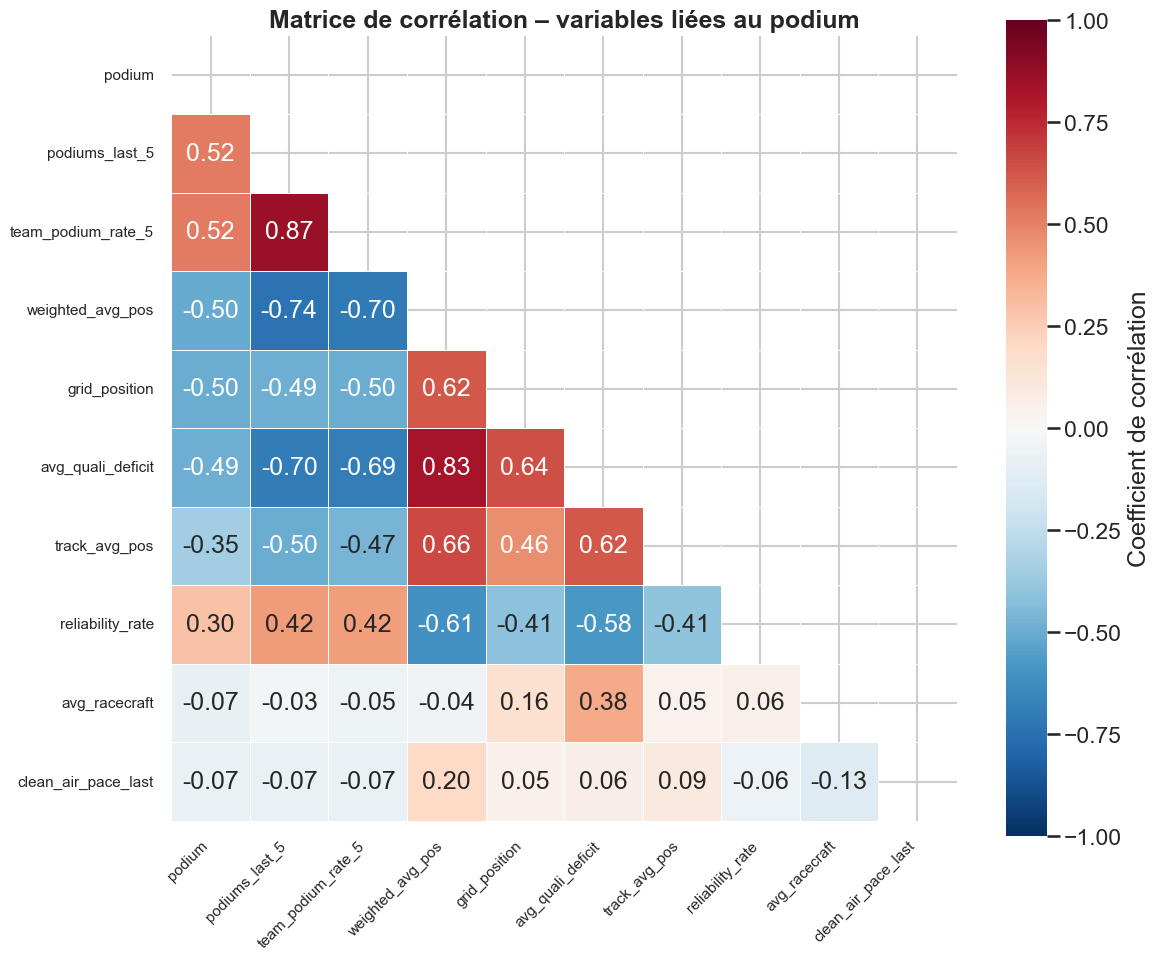

In [241]:
plt.figure(figsize=(12, 10))

cols_corr = [
    'grid_position',          # Posição de largada
    'podiums_last_5',         # Momentum (Pódios recentes)
    'weighted_avg_pos',       # Forma Recente Ponderada
    'avg_racecraft',          # Habilidade de recuperação
    'reliability_rate',       # Confiabilidade
    'track_avg_pos',          # Especialista na pista
    'clean_air_pace_last',    # Ritmo puro na última corrida
    'avg_quali_deficit',      # Habilidade de classificação média
    'team_podium_rate_5',
    'podium',  
]

corr = df[cols_corr].corr()

order = corr['podium'].abs().sort_values(ascending=False).index
corr = corr.loc[order, order]

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.gcf().patch.set_facecolor('white')
ax = sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='RdBu_r',
    vmin=-1, vmax=1,
    center=0,
    square=True,
    linewidths=.5,
    linecolor='white',
    cbar_kws={'label': 'Coefficient de corrélation'}
)

plt.title(
    "Matrice de corrélation – variables liées au podium",
    fontsize=18,
    weight='bold'
)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

ax.tick_params(axis='both', labelsize=11)

plt.tight_layout()
plt.show()


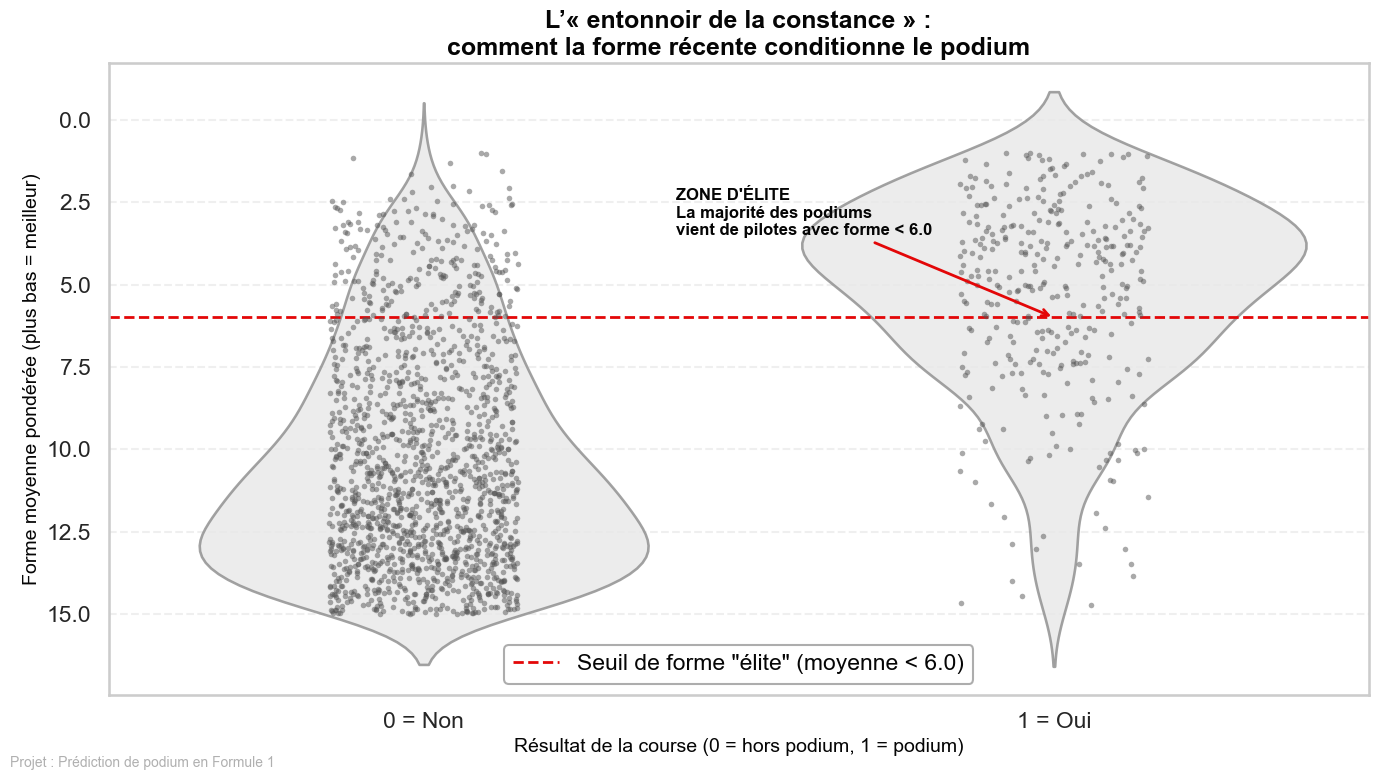

In [ ]:
# L'entonnoir de la constance
# Forme pondérée vs résultat (podium)

plt.figure(figsize=(14, 8))

plot_data = df[df['weighted_avg_pos'] <= 15].copy()

ax = plt.gca()
plt.gcf().patch.set_facecolor('white')
ax.set_facecolor('white')

sns.violinplot(
    x='podium',
    y='weighted_avg_pos',
    data=plot_data,
    inner=None,
    color='#E8E8E8',
    alpha=0.8
)

sns.stripplot(
    x='podium',
    y='weighted_avg_pos',
    data=plot_data,
    jitter=0.15,
    size=4,
    alpha=0.5,
    color='#555555'
)

ax.axhline(
    y=6.0,
    color=f1_red,
    linestyle='--',
    linewidth=2,
    label="Seuil de forme \"élite\" (moyenne < 6.0)"
)


plt.title(
    "L’« entonnoir de la constance » :\ncomment la forme récente conditionne le podium",
    fontsize=18,
    weight='bold',
    color=carbon_black
)

plt.xlabel(
    "Résultat de la course (0 = hors podium, 1 = podium)",
    fontsize=14,
    color=carbon_black
)
plt.ylabel(
    "Forme moyenne pondérée (plus bas = meilleur)",
    fontsize=14,
    color=carbon_black
)


plt.xticks([0, 1], ["0 = Non", "1 = Oui"])


plt.gca().invert_yaxis()

ax.annotate(
    "ZONE D'ÉLITE\nLa majorité des podiums\nvient de pilotes avec forme < 6.0",
    xy=(1, 6),          
    xytext=(0.4, 3.5),  
    arrowprops=dict(
        arrowstyle="->",
        color=f1_red,
        linewidth=2
    ),
    fontsize=12,
    color=carbon_black,
    weight='bold'
)


plt.grid(axis='y', linestyle='--', alpha=0.3)


legend = plt.legend(frameon=True, edgecolor='#999999')
for text in legend.get_texts():
    text.set_color(carbon_black)


plt.gcf().text(
    0.01, 0.02,
    "Projet : Prédiction de podium en Formule 1",
    fontsize=10,
    color=track_grey
)

plt.tight_layout()
plt.show()


---

In [244]:
team_colors = {
    'Red Bull Racing': '#03007A',   
    'Ferrari': '#8B0000',          
    'Mercedes': '#007A73',        
    'McLaren': '#C25A00',          
    'Aston Martin': '#003F3A',     
    'Alpine': '#005FA3',           
    'Williams': '#0039A6',         
    'AlphaTauri': '#1B2E44',       
    'RB': '#1B2E44',
    'Haas F1 Team': '#2B2B2B',     
    'Alfa Romeo': '#5A0000',       
    'Kick Sauber': '#1E7F1E',      
    'Sauber': '#1E7F1E'
}

default_color = '#555555'  


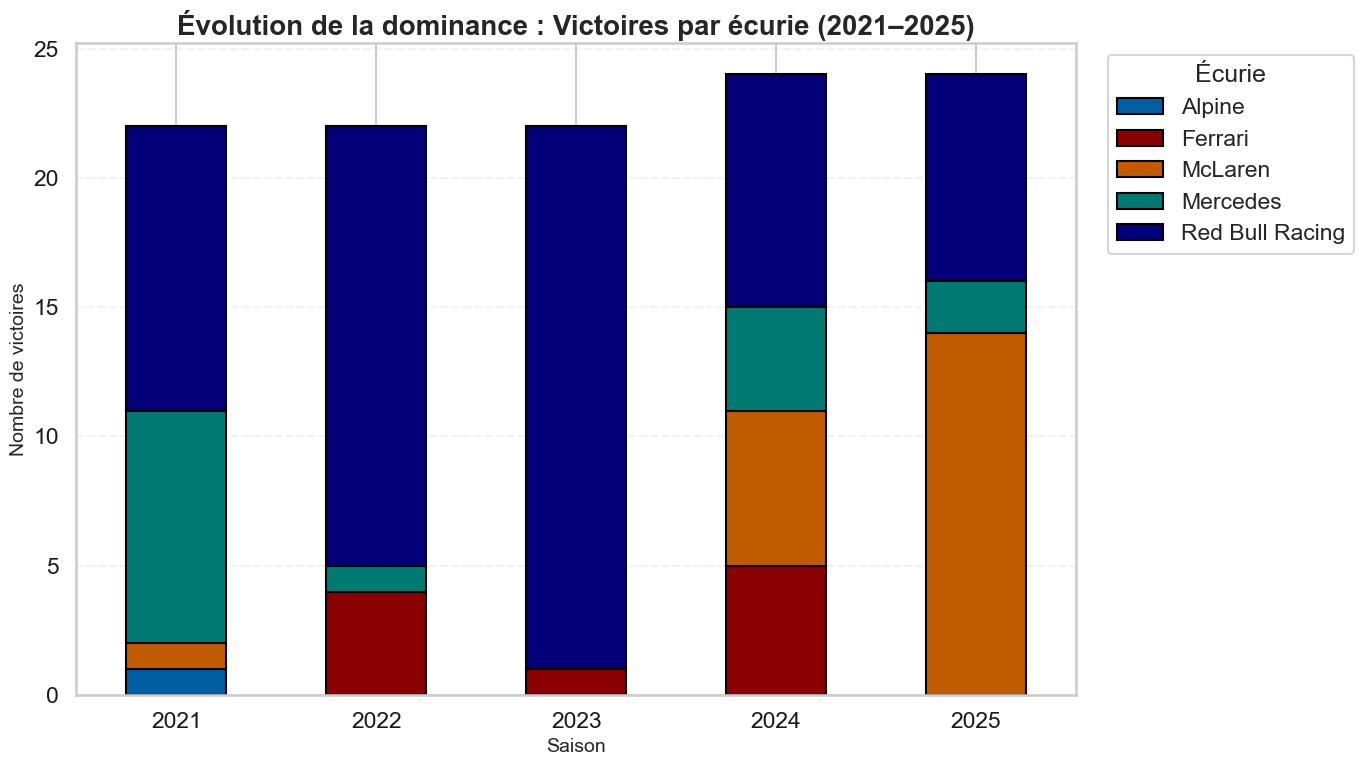

In [245]:
plt.figure(figsize=(14, 8))
ax = plt.gca()

plt.gcf().patch.set_facecolor('white')
ax.set_facecolor('white')


winners = df[df['final_position'] == 1]

wins_per_year = winners.groupby(['season', 'team_name']).size().unstack(fill_value=0)

colors_mapped = [team_colors.get(team, default_color) for team in wins_per_year.columns]

wins_per_year.plot(
    kind='bar',
    stacked=True,
    color=colors_mapped,
    edgecolor='black',
    ax=ax
)

plt.title(
    'Évolution de la dominance : Victoires par écurie (2021–2025)',
    fontsize=20,
    weight='bold'
)

plt.xlabel('Saison', fontsize=14)
plt.ylabel('Nombre de victoires', fontsize=14)

ax.tick_params(colors='#1A1A1A')
plt.xticks(rotation=0)

plt.grid(axis='y', linestyle='--', alpha=0.25)

plt.legend(title='Écurie', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


C:\Users\thzli\AppData\Local\Temp\ipykernel_5404\3123948653.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


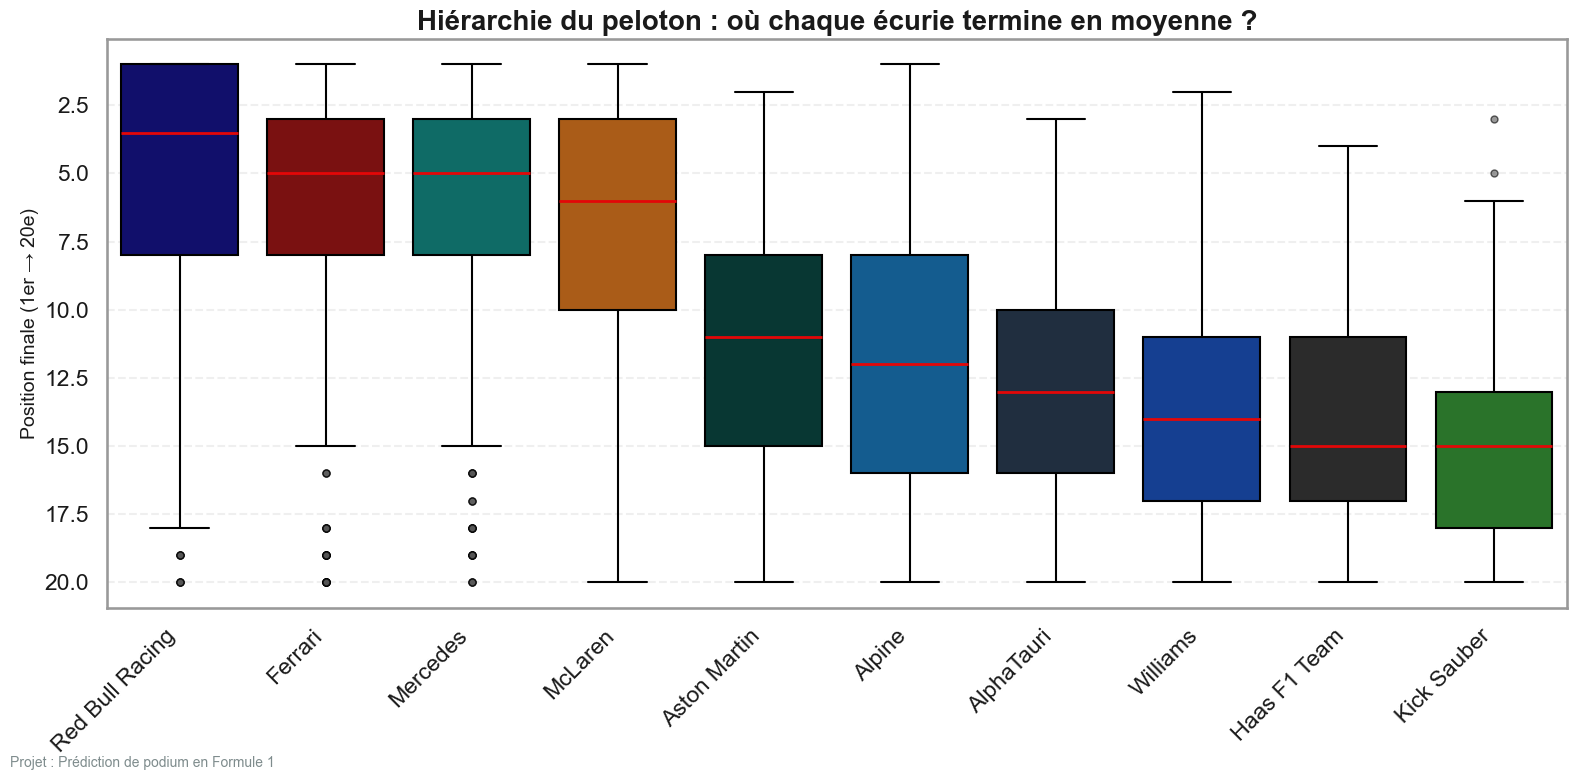

In [ ]:
# HIÉRARCHIE DU GRID
# Performance moyenne par écurie

plt.figure(figsize=(16, 8))
ax = plt.gca()

plt.gcf().patch.set_facecolor('white')
ax.set_facecolor('white')

top_teams = df['team_name'].value_counts().index[:10]
df_top = df[df['team_name'].isin(top_teams)]

my_order = (
    df_top.groupby("team_name")["final_position"]
    .median()
    .sort_values()
    .index
)

sns.boxplot(
    x='team_name',
    y='final_position',
    data=df_top,
    order=my_order,
    palette=team_colors,
    linewidth=1.5,
    boxprops=dict(edgecolor='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    medianprops=dict(color=f1_red, linewidth=2),
    flierprops=dict(
        marker='o',
        markerfacecolor='#555555',
        markeredgecolor='black',
        markersize=5,
        alpha=0.6
    )
)

plt.title(
    "Hiérarchie du peloton : où chaque écurie termine en moyenne ?",
    fontsize=20,
    weight='bold',
    color='#1A1A1A'
)

plt.ylabel("Position finale (1er → 20e)", fontsize=14, color='#1A1A1A')
plt.xlabel("", fontsize=14)

plt.gca().invert_yaxis()

plt.xticks(rotation=45, ha='right')

ax.tick_params(colors='#1A1A1A')

plt.grid(axis='y', linestyle='--', alpha=0.3)

for spine in ax.spines.values():
    spine.set_color('#999999')

plt.gcf().text(
    0.01, 0.02,
    "Projet : Prédiction de podium en Formule 1",
    fontsize=10,
    color='#7f8c8d'
)

plt.tight_layout()
plt.show()


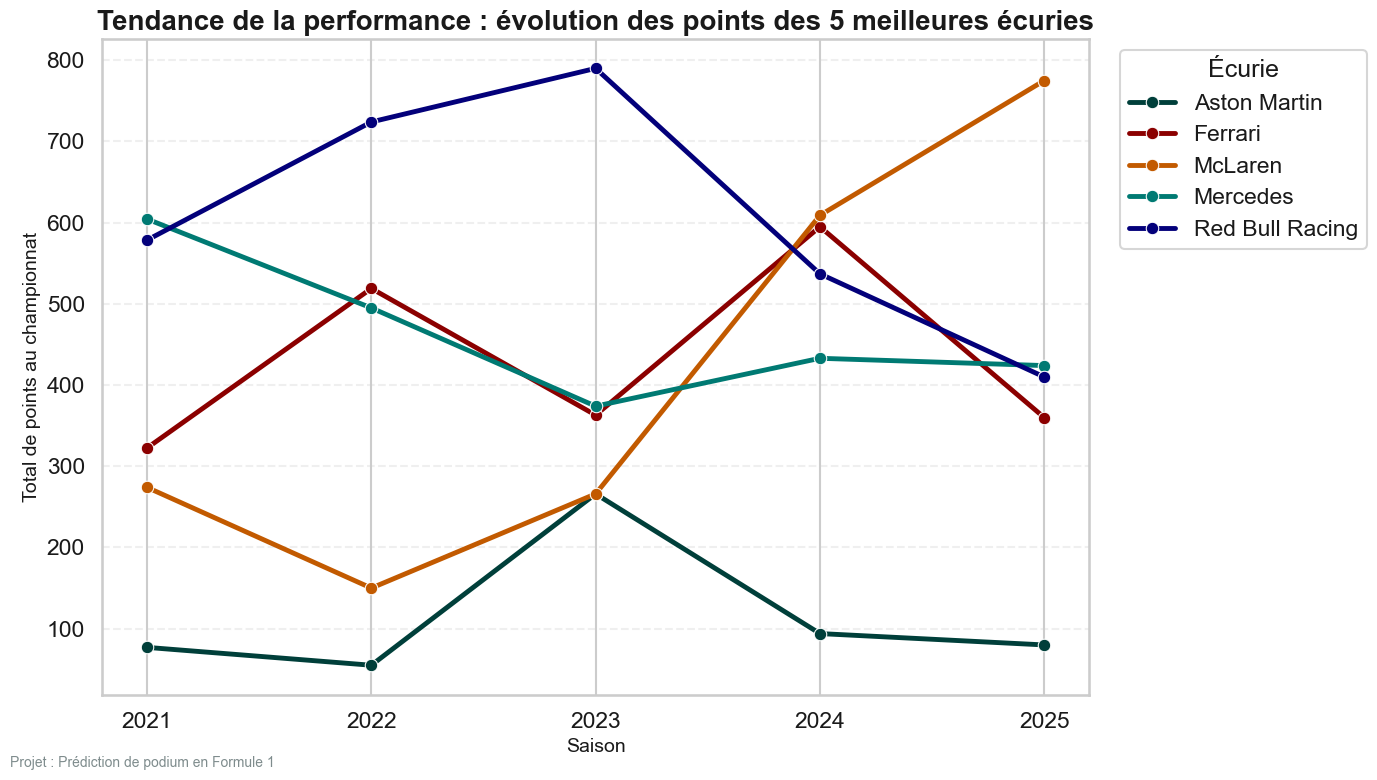

In [247]:
# TENDANCE DES POINTS
# Évolution annuelle des Top 5 écuries

plt.figure(figsize=(14, 8))
ax = plt.gca()

plt.gcf().patch.set_facecolor('white')
ax.set_facecolor('white')

season_points = (
    df.groupby(['season', 'team_name'])['points']
    .sum()
    .reset_index()
)

top_5_teams = (
    season_points.groupby('team_name')['points']
    .sum()
    .nlargest(5)
    .index
)

season_points_filtered = season_points[
    season_points['team_name'].isin(top_5_teams)
]

sns.lineplot(
    data=season_points_filtered,
    x='season',
    y='points',
    hue='team_name',
    palette=team_colors,
    linewidth=3.5,
    marker='o',
    markersize=9
)

plt.title(
    "Tendance de la performance : évolution des points des 5 meilleures écuries",
    fontsize=20,
    weight='bold',
    color='#1A1A1A'
)

plt.xlabel("Saison", fontsize=14, color='#1A1A1A')
plt.ylabel("Total de points au championnat", fontsize=14, color='#1A1A1A')

plt.xticks(season_points['season'].unique())

ax.tick_params(colors='#1A1A1A')

plt.grid(axis='y', linestyle='--', alpha=0.3)

legend = plt.legend(
    title="Écurie",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=True
)

plt.setp(legend.get_title(), color='#1A1A1A')
for text in legend.get_texts():
    text.set_color('#1A1A1A')

plt.gcf().text(
    0.01, 0.02,
    "Projet : Prédiction de podium en Formule 1",
    fontsize=10,
    color='#7f8c8d'
)

plt.tight_layout()
plt.show()


---

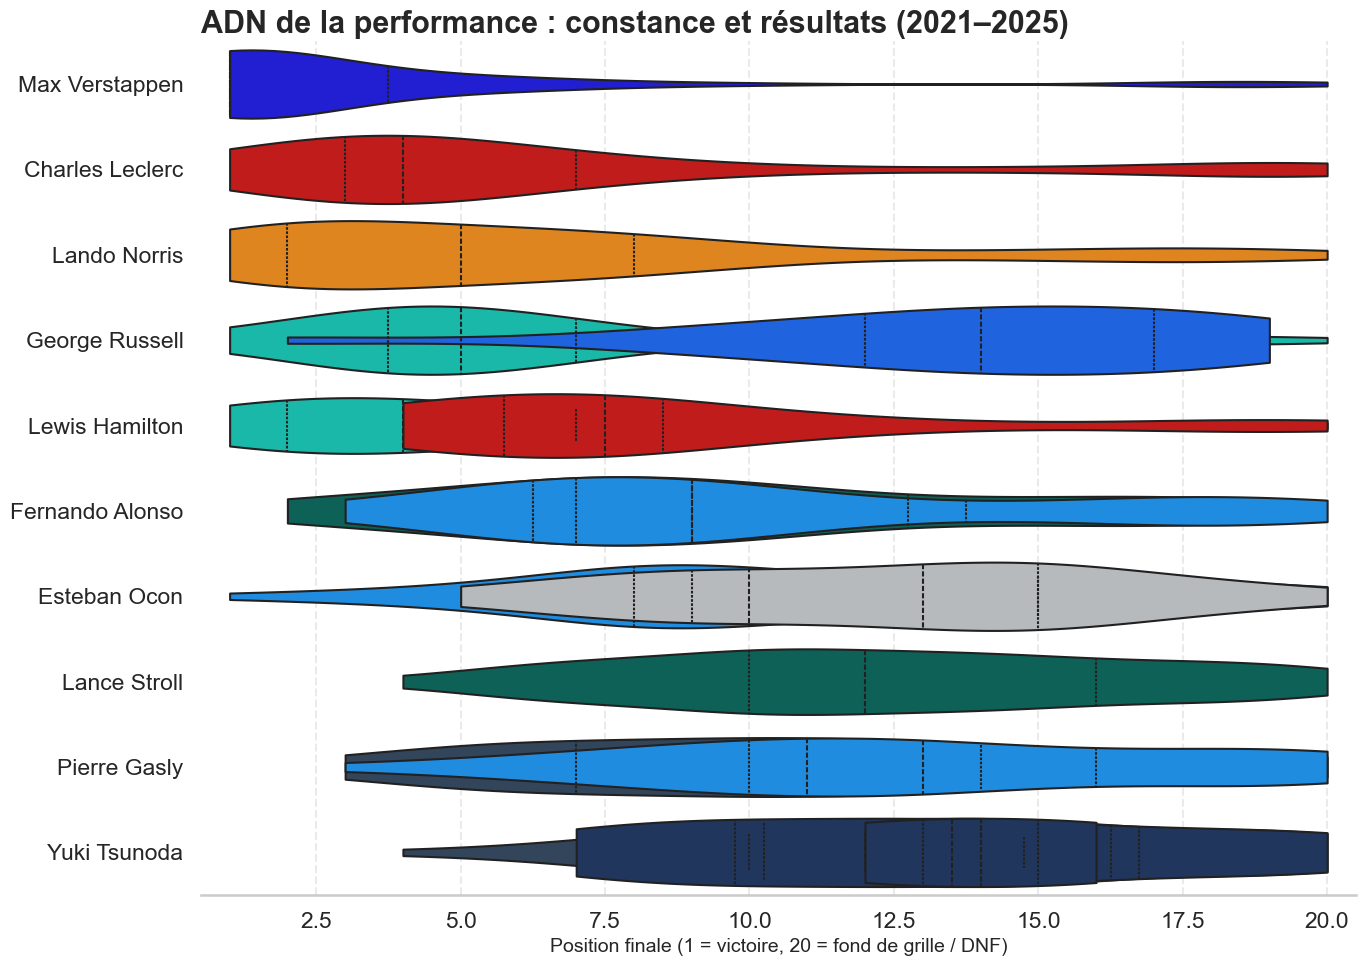

In [ ]:
#  L'ADN DE LA PERFORMANCE (VIOLIN PLOT)

plt.figure(figsize=(14, 10))

ax = plt.gca()
plt.gcf().patch.set_facecolor('white')
ax.set_facecolor('white')

# 1. Top 10 pilotes les plus présents
top_drivers_names = df['driver_name'].value_counts().index[:10]
df_violin = df[df['driver_name'].isin(top_drivers_names)].copy()

# 2. Ordre par médiane de position finale (meilleurs en haut)
order = (
    df_violin.groupby('driver_name')['final_position']
    .median()
    .sort_values()
    .index
)

# 3. Violin plot par pilote (axe Y = nom réel)
sns.violinplot(
    data=df_violin, 
    x='final_position', 
    y='driver_name',
    order=order,
    hue='team_name', 
    palette=final_palette, 
    inner='quart',
    linewidth=1.5,
    dodge=False,
    cut=0
)

plt.title(
    "ADN de la performance : constance et résultats (2021–2025)",
    fontsize=22,
    weight='bold',
    loc='left'
)

plt.xlabel(
    "Position finale (1 = victoire, 20 = fond de grille / DNF)",
    fontsize=14
)
plt.ylabel("", fontsize=12)

plt.xlim(0.5, 20.5)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Retirer la légende (la couleur = écurie déjà implícito)
plt.legend([], [], frameon=False)

sns.despine(left=True)
plt.tight_layout()
plt.show()


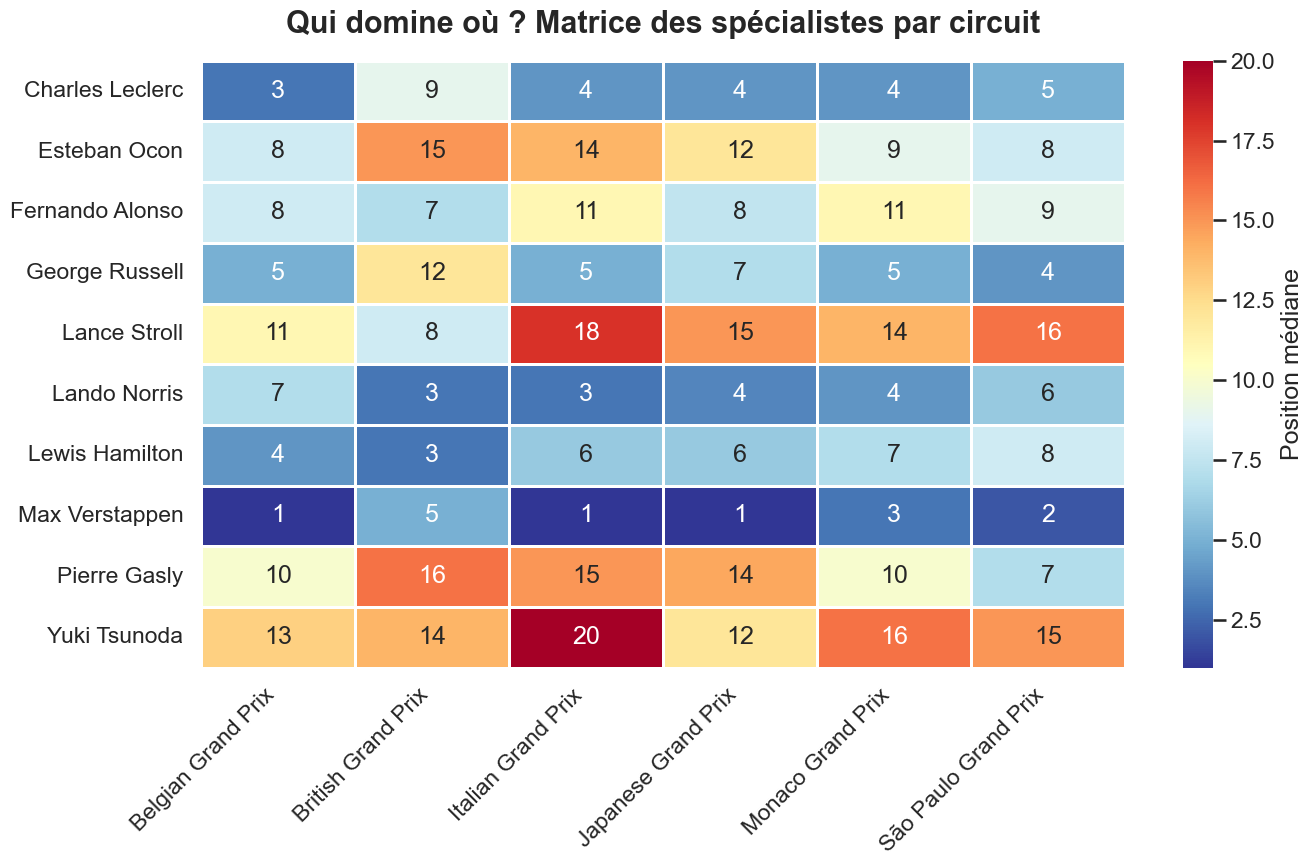

In [ ]:
# MATRICE DES SPÉCIALISTES (HEATMAP)

plt.figure(figsize=(14, 9))

ax = plt.gca()
plt.gcf().patch.set_facecolor('white')
ax.set_facecolor('white')

iconic_tracks = [
    'Monaco Grand Prix', 'British Grand Prix', 'Italian Grand Prix', 
    'Belgian Grand Prix', 'São Paulo Grand Prix', 'Japanese Grand Prix'
]

# Filtrer données
df_tracks = df[
    df['event_name'].isin(iconic_tracks) &
    df['driver_name'].isin(top_drivers_names)
].copy()

# Pivot (index = pilote, colonnes = circuit)
track_matrix = df_tracks.pivot_table(
    index='driver_name',
    columns='event_name',
    values='final_position',
    aggfunc='median'
)

# Heatmap : bleu = meilleurs résultats, rouge = pires
sns.heatmap(
    track_matrix, 
    annot=True, 
    fmt=".0f", 
    cmap="RdYlBu_r",
    linewidths=2, 
    linecolor='white',
    cbar_kws={'label': 'Position médiane'}
)

plt.title(
    "Qui domine où ? Matrice des spécialistes par circuit",
    fontsize=22,
    weight='bold',
    pad=20
)

plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


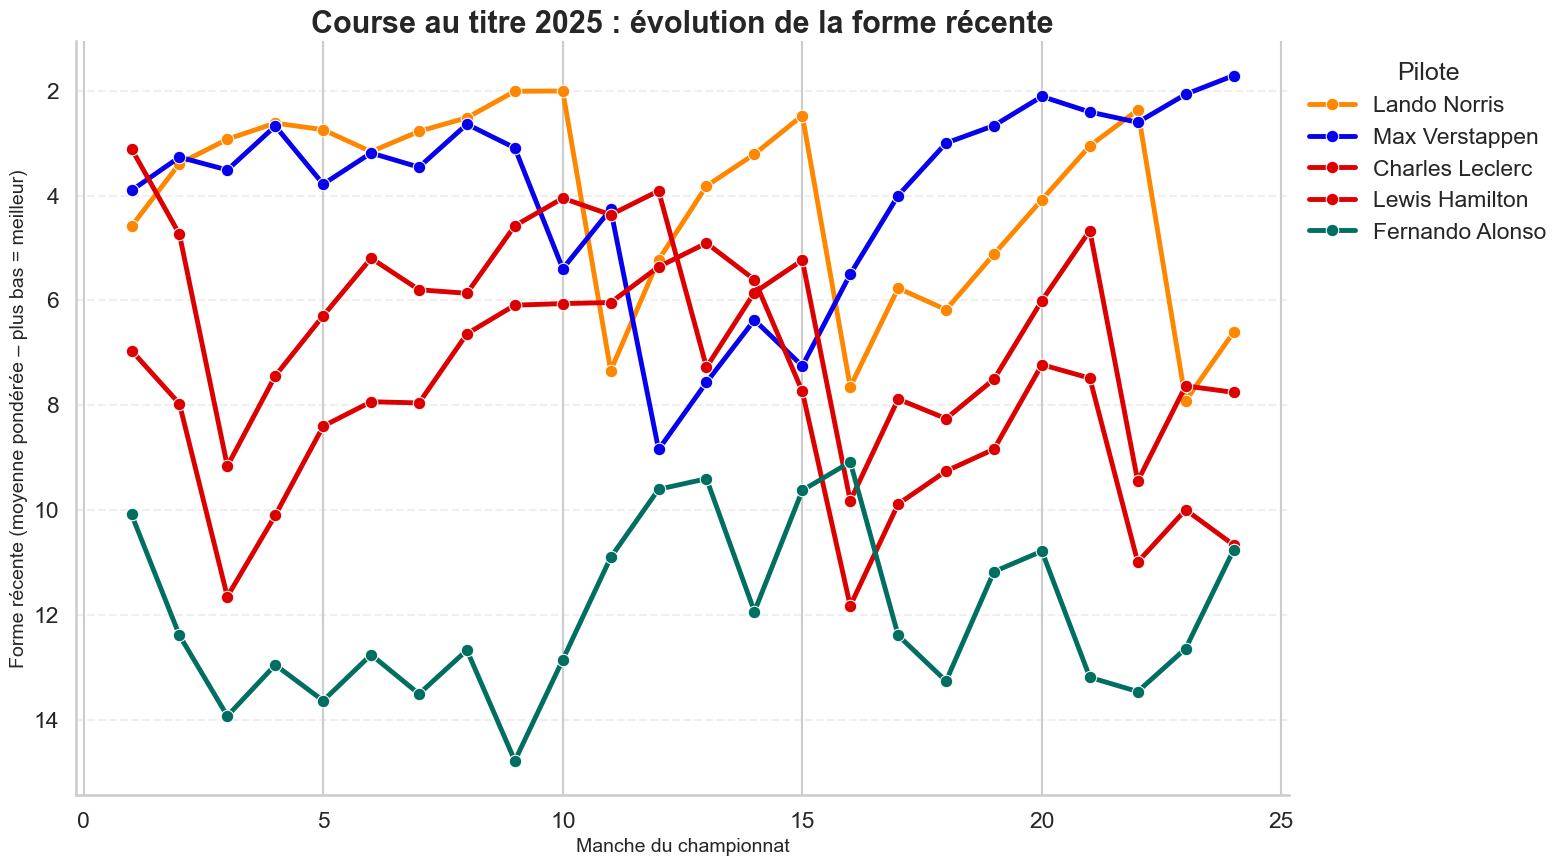

In [ ]:
# ÉVOLUTION DE LA FORME (COURSE AU TITRE)

plt.figure(figsize=(16, 9))

ax = plt.gca()
plt.gcf().patch.set_facecolor('white')
ax.set_facecolor('white')

latest_season = df['season'].max()
top_5_names = top_drivers_names[:5]  
df_trend = df[
    (df['season'] == latest_season) &
    (df['driver_name'].isin(top_5_names))
].copy()

driver_palette = {}
for driver in df_trend['driver_name'].unique():
    team = df_trend[df_trend['driver_name'] == driver]['team_name'].iloc[0]
    driver_palette[driver] = final_palette.get(team, '#333333')

sns.lineplot(
    data=df_trend, 
    x='round', 
    y='weighted_avg_pos', 
    hue='driver_name',
    palette=driver_palette,
    linewidth=3.5,
    marker='o'
)

plt.title(
    f"Course au titre {latest_season} : évolution de la forme récente",
    fontsize=22,
    weight='bold'
)

plt.ylabel(
    "Forme récente (moyenne pondérée – plus bas = meilleur)",
    fontsize=14
)
plt.xlabel("Manche du championnat", fontsize=14)

plt.gca().invert_yaxis()  # 1 = meilleure forme, en haut
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.legend(
    bbox_to_anchor=(1, 1),
    loc='upper left',
    title='Pilote',
    frameon=False
)

sns.despine()
plt.tight_layout()
plt.show()


### Save Features DF

In [235]:
df.columns

Index(['season', 'round', 'event_name', 'location', 'event_date',
       'driver_code', 'driver_number', 'driver_name', 'team_name',
       'grid_position', 'final_position', 'status', 'points', 'total_time_sec',
       'laps_completed', 'avg_lap_time_sec', 'best_lap_time_sec',
       'std_lap_time_sec', 'clean_avg_lap_time_sec', 'n_pitstops',
       'total_pit_time_sec', 'n_stints', 'compounds_used', 'RainProbability',
       'TrackTemp', 'CleanAirPace', 'Sector1_Ratio', 'Sector2_Ratio',
       'Sector3_Ratio', 'Quali_Delta_Pole', 'podium', 'podiums_last_5',
       'team_podium_rate_5', 'weighted_avg_pos', 'pos_gain_raw',
       'avg_racecraft', 'is_finished', 'reliability_rate', 'track_avg_pos',
       'clean_air_pace_raw', 'clean_air_pace_last', 'quali_deficit_score',
       'avg_quali_deficit'],
      dtype='object')

In [252]:
cols_to_save = [
   
    'season', 'round', 'event_name', 'location', 'event_date',
    'driver_code', 'driver_number', 'driver_name', 'team_name',
    
    # --- Inputs ---
    'grid_position',          # Posição de largada
    'podiums_last_5',         # Momentum (Pódios recentes)
    'weighted_avg_pos',       # Forma Recente Ponderada
    'avg_racecraft',          # Habilidade de recuperação
    'reliability_rate',       # Confiabilidade
    'track_avg_pos',          # Especialista na pista
    'clean_air_pace_last',    # Ritmo puro na última corrida
    'avg_quali_deficit',      # Habilidade de classificação média
    'team_podium_rate_5',
    'podium',  
]


cols_existing = [c for c in cols_to_save if c in df.columns]
df_final_save = df[cols_existing].copy()


before_len = len(df_final_save)
df_final_save = df_final_save.dropna(subset=['weighted_avg_pos', 'clean_air_pace_last'])
after_len = len(df_final_save)

filename = 'f1_model_training_data_final.csv'
df_final_save.to_csv(filename, index=False)

display(df_final_save.head())

,season,round,event_name,location,event_date,driver_code,driver_number,driver_name,team_name,grid_position,podiums_last_5,weighted_avg_pos,avg_racecraft,reliability_rate,track_avg_pos,clean_air_pace_last,avg_quali_deficit,team_podium_rate_5,podium
20,2021,2,Emilia Romagna Grand Prix,Imola,2021-04-18,33,33,Max Verstappen,Red Bull Racing,3.0,0.0,2.0,0.0,0.8,2.0,98.297601,0.5,0.0,1
21,2021,2,Emilia Romagna Grand Prix,Imola,2021-04-18,44,44,Lewis Hamilton,Mercedes,1.0,0.0,1.0,0.0,0.8,1.0,98.297601,0.5,0.0,1
22,2021,2,Emilia Romagna Grand Prix,Imola,2021-04-18,4,4,Lando Norris,McLaren,7.0,0.0,4.0,0.0,0.8,4.0,98.297601,0.5,0.0,1
23,2021,2,Emilia Romagna Grand Prix,Imola,2021-04-18,16,16,Charles Leclerc,Ferrari,4.0,0.0,6.0,0.0,0.8,6.0,98.297601,0.5,0.0,0
24,2021,2,Emilia Romagna Grand Prix,Imola,2021-04-18,55,55,Carlos Sainz,Ferrari,11.0,0.0,8.0,0.0,0.8,8.0,98.297601,0.5,0.0,0
